# 模型性能测试流程
模型加载

In [1]:
import sys
import numpy as np
import requests
import os
import pandas as pd
import random
import obspy
import matplotlib.pyplot as plt
import numpy.ma as ma
from scipy import stats
from sklearn.linear_model import LinearRegression
sys.path.append("/home/disk/wd_black/wzm/Sustech_Pulse/src/finetune")
from diting_all import DiTing_EQDet_magnitude_predict,DiTing_EQDet_magnitude_predict_4_7,DiTing_EQDet_magnitude_predict_perturbation

# server_ip为运行服务的机器ip,
# server_port 为 server_conf.yml 中配置的端口号
#server_ip = "127.0.0.1"
#server_port = "10090"

# 赛题计算函数

In [9]:
def model_solution(an_dir,exam_dir,out_dir):
    #主程序开始：读取答案，归零分数，遍历赛题并解答、计算误差算分数
    answer = pd.read_csv(an_dir,sep='\s+' ,names=['filename','magnitude'])
    score = 0
    sumdiff = 0
    with open(out_dir,"w") as f:
        f.write("i mag pre_mag diff\n")
    for i in range(0,len(answer)):
        try:
            file_name  = answer.iloc[i,0]
            file_name  = os.path.basename(file_name)
            st = obspy.read('%s/%s' %(exam_dir,file_name))
            # x 应该具有形状 (n,3,10000), 表示 n 条 3 分量波形, 每条波形有 10000 个点
            # 第一分量为 Z, 第二分量为 N, 第三分量为 E.
            output = DiTing_EQDet_magnitude_predict(st) 

            #策略1:在一定范围内给结果加常数
            if output >= 3 and output < 5:
                output += 0.6
            if output >= 2 and output < 3:
                output += 0.6
            #策略2:双模型取最大
            #output2 = DiTing_EQDet_magnitude_predict_4_7(st)
            #if output1 < 2 or output2 < 2:
            #   output = 2
            #else:
            #output = max(output1, output2)
            
            #策略3:最小二乘法优化
            #output = (output - 0.3759)/0.7957
            
            # 在向 api 提交数据的时候,需要将数组转换成 list,
            # 并封装到字典里, 字典的 key 为 'array_data'
            # data = {'array_data': np.nan_to_num(st, nan=0.0, posinf=1e10, neginf=-1e10).tolist()}

            # # 通过对应的 api 接口调用 DiTing 模型进行计算
            # # 接口统一为 inference, 根据配置文件确定不同的任务类型
            #output = requests.post(f'http://{server_ip}:{server_port}/inference/', json=data)

            #  打印结果
            print(output, answer.iloc[i,1])
            diff = abs(output - answer.iloc[i,1])
            print(diff)
            sumdiff += diff
            if diff <= 0.2:
                score += 1
            elif diff <= 0.6:
                score += 1.5 - 2.5*diff
            with open(out_dir, "a") as f:
                f.write(f"{i+1} {answer.iloc[i,1]} {output:.2f} {diff:.2f}\n")
        except FileNotFoundError as e:
            print(f"题目{i}处理时遇到问题，自动跳过")   
            continue
        except ValueError as e:
            print(f"题目{i}处理时遇到问题，自动跳过")   
            continue
    avgdiff = sumdiff/i
    result = [score,avgdiff]
    return result

# 单台测试区

In [ ]:
stream = obspy.read('/home/disk/wd_black/wzm/Sustech_Pulse/test_data/10-exam/T2/T2.A.Q0010.mseed')
#stream = obspy.read('/home/disk/wd_black/wzm/Sustech_Pulse/test_data/10-exam/T2/T2.A.T0511.mseed')
stream.detrend('demean') #去均值
stream.detrend('linear') #去趋势
output = DiTing_EQDet_magnitude_predict(stream)
print(output)

# 计算主程序——单一月份

In [ ]:
#设置月份（如：06、07、08、09、10）
month = "11"

#自动修改答案、赛题路径
an_data = "/home/disk/wd_black/wzm/Sustech_Pulse/test_data/%s-an/T2.an" % month
exam_data = "/home/disk/wd_black/wzm/Sustech_Pulse/test_data/%s-exam/T2" %month
out_data = "/home/disk/wd_black/wzm/Sustech_Pulse/src/finetune/zbk/emg_output_%s.txt" %month
result = model_solution(an_data,exam_data,out_data)
print(result)

In [ ]:
print(f'{month}月题目的得分为：{result[0]}\n  平均误差为：{result[1]}')

绘制单月图

In [ ]:
data = pd.read_csv("./emg_output_%s.txt" % month,sep='\s+')
x = data.iloc[:,0]
y = data.iloc[:,1]

plt.scatter(x, y)
plt.xlabel('magnitude')
plt.ylabel('predict_mag')
plt.title('error distribution')
plt.xlim(0, 7)   
plt.ylim(0, 7)

xmin, xmax = plt.xlim()  # 获取当前x轴范围
plt.plot([xmin, xmax], [xmin, xmax], 'b--', label='y=x', linewidth=1.5)
plt.legend()  # 显示图例

plt.show()

# 循环5轮比赛所有试题

In [10]:
#月份列表
months = ['06','07','08','09','10','11']

#初始化 得分、平均误差
scores = [0] * len(months)  
avgdiffs = [0] * len(months)

#开始计算
for j,month in enumerate(months):
    an_data = "/home/disk/wd_black/wzm/Sustech_Pulse/test_data/%s-an/T2.an" % month
    exam_data = "/home/disk/wd_black/wzm/Sustech_Pulse/test_data/%s-exam/T2" %month
    out_data = "/home/disk/wd_black/wzm/Sustech_Pulse/src/finetune/zbk/emg_output_%s.txt" %month
    result = model_solution(an_data,exam_data,out_data)
    scores[j] = result[0]
    avgdiffs[j] = result[1]
print(f'月份：{months} \n')
print(f'得分：{scores} \n')
print(f'误差：{avgdiffs} \n')

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  7.21it/s]


2.98 4.3
1.3199999999999998


100%|██████████| 1/1 [00:00<00:00, 11.78it/s]


4.9799999999999995 4.5
0.47999999999999954


100%|██████████| 1/1 [00:00<00:00, 16.15it/s]


3.49 4.1
0.6099999999999994


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


3.65 4.3
0.6499999999999999


100%|██████████| 1/1 [00:00<00:00, 14.26it/s]


3.67 4.1
0.4299999999999997


100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


4.4399999999999995 4.3
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 14.57it/s]


5.09 4.5
0.5899999999999999


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


3.31 4.3
0.9899999999999998


100%|██████████| 1/1 [00:00<00:00, 13.41it/s]


4.32 4.2
0.1200000000000001


100%|██████████| 1/1 [00:00<00:00, 17.00it/s]


3.56 4.2
0.6400000000000001


100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


4.739999999999999 4.0
0.7399999999999993


100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


4.6499999999999995 4.1
0.5499999999999998


100%|██████████| 1/1 [00:00<00:00, 19.99it/s]


4.21 4.3
0.08999999999999986


100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


3.06 4.3
1.2399999999999998


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


4.12 4.1
0.020000000000000462


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


4.41 4.5
0.08999999999999986


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


4.37 4.0
0.3700000000000001


100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


3.5100000000000002 4.1
0.5899999999999994


100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


3.6 4.3
0.6999999999999997


100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


5.1 4.8
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 16.38it/s]


4.1499999999999995 4.2
0.05000000000000071


100%|██████████| 1/1 [00:00<00:00, 14.81it/s]


4.1499999999999995 4.3
0.15000000000000036


100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


4.9399999999999995 4.8
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 18.63it/s]


3.4 4.2
0.8000000000000003


100%|██████████| 1/1 [00:00<00:00, 13.62it/s]


3.0100000000000002 4.0
0.9899999999999998


100%|██████████| 1/1 [00:00<00:00, 16.87it/s]


4.18 4.0
0.17999999999999972


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4.76 4.0
0.7599999999999998


100%|██████████| 1/1 [00:00<00:00, 18.39it/s]


3.87 4.2
0.33000000000000007


100%|██████████| 1/1 [00:00<00:00, 13.26it/s]


4.25 4.3
0.04999999999999982


100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


3.4 4.0
0.6000000000000001


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


3.0100000000000002 4.0
0.9899999999999998


100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


3.74 4.1
0.35999999999999943


100%|██████████| 1/1 [00:00<00:00, 18.56it/s]


5.2299999999999995 4.5
0.7299999999999995


100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


5.3 5.0
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 13.50it/s]


4.7299999999999995 4.0
0.7299999999999995


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


4.0 4.1
0.09999999999999964


100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


3.68 4.2
0.52


100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


4.63 4.0
0.6299999999999999


100%|██████████| 1/1 [00:00<00:00, 15.63it/s]


4.3 4.6
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 15.05it/s]


4.68 4.2
0.47999999999999954


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


2.89 4.6
1.7099999999999995


100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


3.65 4.3
0.6499999999999999


100%|██████████| 1/1 [00:00<00:00, 19.88it/s]


3.2800000000000002 4.1
0.8199999999999994


100%|██████████| 1/1 [00:00<00:00, 20.99it/s]


4.14 4.2
0.0600000000000005


100%|██████████| 1/1 [00:00<00:00, 17.06it/s]


4.04 4.0
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00, 16.06it/s]


4.42 4.0
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00, 15.31it/s]


3.71 4.0
0.29000000000000004


100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


3.14 4.2
1.06


100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


3.88 4.2
0.3200000000000003


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


4.819999999999999 4.2
0.6199999999999992


100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


3.69 4.2
0.5100000000000002


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


3.86 4.5
0.6400000000000001


100%|██████████| 1/1 [00:00<00:00, 11.48it/s]


5.069999999999999 4.1
0.9699999999999998


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]


4.16 4.6
0.4399999999999995


100%|██████████| 1/1 [00:00<00:00, 11.29it/s]


3.5300000000000002 4.0
0.46999999999999975


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


4.109999999999999 4.8
0.6900000000000004


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


4.1 4.0
0.09999999999999964


100%|██████████| 1/1 [00:00<00:00, 11.82it/s]


2.93 4.3
1.3699999999999997


100%|██████████| 1/1 [00:00<00:00, 13.82it/s]


4.13 5.4
1.2700000000000005


100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


3.25 4.5
1.25


100%|██████████| 1/1 [00:00<00:00, 16.58it/s]


4.93 4.1
0.8300000000000001


100%|██████████| 1/1 [00:00<00:00, 18.61it/s]


4.75 5.3
0.5499999999999998


100%|██████████| 1/1 [00:00<00:00, 11.37it/s]


5.21 4.0
1.21


100%|██████████| 1/1 [00:00<00:00, 16.05it/s]


4.2 4.3
0.09999999999999964


100%|██████████| 1/1 [00:00<00:00, 12.91it/s]


3.69 4.2
0.5100000000000002


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


4.38 4.2
0.17999999999999972


100%|██████████| 1/1 [00:00<00:00, 14.01it/s]


3.37 4.4
1.0300000000000002


100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


3.99 4.8
0.8099999999999996


100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


3.23 4.1
0.8699999999999997


100%|██████████| 1/1 [00:00<00:00, 18.41it/s]


4.16 4.0
0.16000000000000014


100%|██████████| 1/1 [00:00<00:00, 20.24it/s]


4.27 4.2
0.0699999999999994


100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


3.47 4.5
1.0299999999999998


100%|██████████| 1/1 [00:00<00:00, 11.49it/s]


4.54 4.2
0.33999999999999986


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]


5.069999999999999 4.6
0.46999999999999975


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


4.07 4.3
0.22999999999999954


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


4.989999999999999 4.5
0.4899999999999993


100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


3.2600000000000002 4.5
1.2399999999999998


100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


3.65 4.5
0.8500000000000001


100%|██████████| 1/1 [00:00<00:00, 11.79it/s]


4.84 4.5
0.33999999999999986


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


5.34 4.8
0.54


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


3.93 4.0
0.06999999999999984


100%|██████████| 1/1 [00:00<00:00, 19.44it/s]


4.59 4.4
0.1899999999999995


100%|██████████| 1/1 [00:00<00:00, 18.26it/s]


3.7600000000000002 4.0
0.23999999999999977


100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


4.53 4.1
0.4300000000000006


100%|██████████| 1/1 [00:00<00:00, 11.57it/s]


4.17 4.3
0.1299999999999999


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


3.71 4.0
0.29000000000000004


100%|██████████| 1/1 [00:00<00:00, 14.77it/s]


5.3 4.8
0.5


100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


4.01 4.0
0.009999999999999787


100%|██████████| 1/1 [00:00<00:00, 15.52it/s]


4.88 4.2
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


3.02 4.1
1.0799999999999996


100%|██████████| 1/1 [00:00<00:00, 13.86it/s]


4.55 4.9
0.35000000000000053


100%|██████████| 1/1 [00:00<00:00, 13.90it/s]


4.71 4.3
0.41000000000000014


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


4.08 4.9
0.8200000000000003


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


4.859999999999999 4.3
0.5599999999999996


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


3.25 4.1
0.8499999999999996


100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


3.35 5.0
1.65


100%|██████████| 1/1 [00:00<00:00, 12.56it/s]


4.5 4.5
0.0


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


3.67 4.5
0.8300000000000001


100%|██████████| 1/1 [00:00<00:00, 13.21it/s]


3.8400000000000003 4.0
0.1599999999999997


100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


5.0 5.3
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 17.20it/s]


4.03 4.8
0.7699999999999996


100%|██████████| 1/1 [00:00<00:00, 17.33it/s]


4.619999999999999 4.6
0.019999999999999574


100%|██████████| 1/1 [00:00<00:00, 18.10it/s]


3.06 4.2
1.1400000000000001


100%|██████████| 1/1 [00:00<00:00, 15.43it/s]


3.42 4.1
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00, 18.94it/s]


5.39 4.5
0.8899999999999997


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


4.949999999999999 4.9
0.049999999999998934


100%|██████████| 1/1 [00:00<00:00, 12.70it/s]


4.39 4.1
0.29000000000000004


100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


4.3999999999999995 4.1
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 17.02it/s]


4.81 4.5
0.3099999999999996


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


3.93 4.2
0.27


100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


4.84 4.2
0.6399999999999997


100%|██████████| 1/1 [00:00<00:00, 19.66it/s]


4.22 4.1
0.1200000000000001


100%|██████████| 1/1 [00:00<00:00, 14.85it/s]


2.91 4.1
1.1899999999999995


100%|██████████| 1/1 [00:00<00:00, 18.03it/s]


4.1499999999999995 4.0
0.14999999999999947


100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


3.2 4.1
0.8999999999999995


100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


4.34 4.5
0.16000000000000014


100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


3.44 5.0
1.56


100%|██████████| 1/1 [00:00<00:00, 11.39it/s]


3.74 4.0
0.2599999999999998


100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


3.18 4.1
0.9199999999999995


100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


5.1899999999999995 4.8
0.3899999999999997


100%|██████████| 1/1 [00:00<00:00, 15.68it/s]


3.66 4.1
0.4399999999999995


100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


4.89 4.5
0.3899999999999997


100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


4.72 4.9
0.1800000000000006


100%|██████████| 1/1 [00:00<00:00, 19.59it/s]


4.58 4.5
0.08000000000000007


100%|██████████| 1/1 [00:00<00:00, 16.29it/s]


3.83 4.2
0.3700000000000001


100%|██████████| 1/1 [00:00<00:00, 17.01it/s]


4.06 4.0
0.05999999999999961


100%|██████████| 1/1 [00:00<00:00, 19.08it/s]


3.38 4.1
0.7199999999999998


100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


4.8 4.5
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 19.17it/s]


4.96 4.4
0.5599999999999996


100%|██████████| 1/1 [00:00<00:00, 19.75it/s]


4.55 5.0
0.4500000000000002


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


4.4799999999999995 4.2
0.27999999999999936


100%|██████████| 1/1 [00:00<00:00, 16.93it/s]


4.359999999999999 4.4
0.040000000000000924


100%|██████████| 1/1 [00:00<00:00, 14.90it/s]


2.95 4.8
1.8499999999999996


100%|██████████| 1/1 [00:00<00:00, 12.80it/s]


3.3400000000000003 4.3
0.9599999999999995


100%|██████████| 1/1 [00:00<00:00, 12.74it/s]


5.54 4.8
0.7400000000000002


100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


4.59 4.2
0.3899999999999997


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


5.08 4.2
0.8799999999999999


100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


4.38 4.2
0.17999999999999972


100%|██████████| 1/1 [00:00<00:00, 17.59it/s]


4.21 5.8
1.5899999999999999


100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


4.71 4.1
0.6100000000000003


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


4.699999999999999 4.5
0.1999999999999993


100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


4.32 4.2
0.1200000000000001


100%|██████████| 1/1 [00:00<00:00, 12.84it/s]


4.25 4.2
0.04999999999999982


100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


3.02 4.0
0.98


100%|██████████| 1/1 [00:00<00:00, 10.46it/s]


3.5300000000000002 4.1
0.5699999999999994


100%|██████████| 1/1 [00:00<00:00, 10.86it/s]


5.02 4.5
0.5199999999999996


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


3.21 4.0
0.79


100%|██████████| 1/1 [00:00<00:00, 12.65it/s]


4.14 4.7
0.5600000000000005


100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


4.46 4.0
0.45999999999999996


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


3.63 5.0
1.37


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


4.55 5.4
0.8500000000000005


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


3.5100000000000002 4.0
0.48999999999999977


100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


3.2800000000000002 4.4
1.12


100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


3.5 4.1
0.5999999999999996


100%|██████████| 1/1 [00:00<00:00, 17.72it/s]


4.739999999999999 5.0
0.2600000000000007


100%|██████████| 1/1 [00:00<00:00, 12.21it/s]


4.619999999999999 4.3
0.3199999999999994


100%|██████████| 1/1 [00:00<00:00, 12.41it/s]


3.5100000000000002 4.0
0.48999999999999977


100%|██████████| 1/1 [00:00<00:00, 19.51it/s]


4.4399999999999995 4.8
0.3600000000000003


100%|██████████| 1/1 [00:00<00:00, 11.13it/s]


3.58 4.0
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00, 17.94it/s]


4.28 4.3
0.019999999999999574


100%|██████████| 1/1 [00:00<00:00, 14.95it/s]


3.69 4.1
0.4099999999999997


100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


4.359999999999999 4.2
0.15999999999999925


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


3.06 4.8
1.7399999999999998


100%|██████████| 1/1 [00:00<00:00, 17.53it/s]


4.17 4.2
0.03000000000000025


100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


3.74 5.0
1.2599999999999998


100%|██████████| 1/1 [00:00<00:00, 19.29it/s]


3.2800000000000002 4.0
0.7199999999999998


100%|██████████| 1/1 [00:00<00:00, 15.84it/s]


3.74 4.1
0.35999999999999943


100%|██████████| 1/1 [00:00<00:00, 13.58it/s]


4.359999999999999 4.2
0.15999999999999925


100%|██████████| 1/1 [00:00<00:00, 16.78it/s]


3.6 4.0
0.3999999999999999


100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


5.0 4.5
0.5


100%|██████████| 1/1 [00:00<00:00, 17.95it/s]


2.8400000000000003 4.0
1.1599999999999997


100%|██████████| 1/1 [00:00<00:00, 16.21it/s]


3.38 4.8
1.42


100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


4.359999999999999 4.1
0.2599999999999998


100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


4.16 4.0
0.16000000000000014


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


5.05 4.6
0.4500000000000002


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


4.7299999999999995 4.1
0.6299999999999999


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


4.53 4.8
0.2699999999999996


100%|██████████| 1/1 [00:00<00:00, 15.35it/s]


3.77 4.5
0.73


100%|██████████| 1/1 [00:00<00:00, 12.67it/s]


3.24 4.5
1.2599999999999998


100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


3.85 4.1
0.24999999999999956


100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


4.79 5.4
0.6100000000000003


100%|██████████| 1/1 [00:00<00:00, 13.99it/s]


4.3999999999999995 5.8
1.4000000000000004


100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


4.16 5.3
1.1399999999999997


100%|██████████| 1/1 [00:00<00:00, 14.00it/s]


4.06 5.3
1.2400000000000002


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


4.55 5.3
0.75


100%|██████████| 1/1 [00:00<00:00, 12.42it/s]


5.08 5.8
0.7199999999999998


100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


4.33 5.3
0.9699999999999998


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


4.27 5.3
1.0300000000000002


100%|██████████| 1/1 [00:00<00:00, 13.15it/s]


4.64 5.3
0.6600000000000001


100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


4.71 5.3
0.5899999999999999


100%|██████████| 1/1 [00:00<00:00, 14.56it/s]


4.739999999999999 5.8
1.0600000000000005


100%|██████████| 1/1 [00:00<00:00, 17.80it/s]


4.14 5.8
1.6600000000000001


100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


4.52 5.0
0.4800000000000004


100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


4.13 5.3
1.17


100%|██████████| 1/1 [00:00<00:00, 19.45it/s]


3.7 5.3
1.5999999999999996


100%|██████████| 1/1 [00:00<00:00, 15.14it/s]


4.24 5.8
1.5599999999999996


100%|██████████| 1/1 [00:00<00:00, 15.95it/s]


4.42 5.3
0.8799999999999999


100%|██████████| 1/1 [00:00<00:00, 21.37it/s]


4.79 6.1
1.3099999999999996


100%|██████████| 1/1 [00:00<00:00, 24.76it/s]


5.52 6.1
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 22.27it/s]


5.4399999999999995 6.1
0.6600000000000001


100%|██████████| 1/1 [00:00<00:00, 13.59it/s]


5.239999999999999 5.0
0.23999999999999932


100%|██████████| 1/1 [00:00<00:00, 17.39it/s]


5.52 5.0
0.5199999999999996


100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


5.29 5.0
0.29000000000000004


100%|██████████| 1/1 [00:00<00:00, 19.03it/s]


4.9399999999999995 5.0
0.0600000000000005


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


3.83 5.4
1.5700000000000003


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


4.1899999999999995 5.4
1.2100000000000009


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


4.739999999999999 5.4
0.660000000000001


100%|██████████| 1/1 [00:00<00:00, 16.73it/s]


4.54 5.4
0.8600000000000003


100%|██████████| 1/1 [00:00<00:00, 15.79it/s]


4.33 5.4
1.0700000000000003


100%|██████████| 1/1 [00:00<00:00, 12.43it/s]


4.56 5.4
0.8400000000000007


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


3.94 5.2
1.2600000000000002


100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


3.43 5.2
1.77


100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


3.24 5.2
1.96


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


4.25 5.2
0.9500000000000002


100%|██████████| 1/1 [00:00<00:00, 12.93it/s]


3.79 5.2
1.4100000000000001


100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


4.51 5.2
0.6900000000000004


100%|██████████| 1/1 [00:00<00:00, 12.09it/s]


3.66 5.2
1.54


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


3.63 5.2
1.5700000000000003


100%|██████████| 1/1 [00:00<00:00, 12.62it/s]


3.87 5.2
1.33


100%|██████████| 1/1 [00:00<00:00, 16.10it/s]


3.77 5.2
1.4300000000000002


100%|██████████| 1/1 [00:00<00:00, 12.15it/s]


3.63 5.2
1.5700000000000003


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


3.25 5.2
1.9500000000000002


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


3.48 5.2
1.7200000000000002


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


3.49 5.2
1.71


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


3.5100000000000002 5.2
1.69


100%|██████████| 1/1 [00:00<00:00, 13.04it/s]


3.77 5.2
1.4300000000000002


100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


3.74 5.2
1.46


100%|██████████| 1/1 [00:00<00:00, 13.14it/s]


5.05 5.2
0.15000000000000036


100%|██████████| 1/1 [00:00<00:00, 10.54it/s]


4.6 5.2
0.6000000000000005


100%|██████████| 1/1 [00:00<00:00, 12.33it/s]


4.33 5.2
0.8700000000000001


100%|██████████| 1/1 [00:00<00:00, 16.91it/s]


4.949999999999999 5.2
0.2500000000000009


100%|██████████| 1/1 [00:00<00:00, 12.90it/s]


4.21 5.2
0.9900000000000002


100%|██████████| 1/1 [00:00<00:00, 10.98it/s]


3.92 5.2
1.2800000000000002


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


4.6899999999999995 5.2
0.5100000000000007


100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


3.67 5.2
1.5300000000000002


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


3.8200000000000003 5.2
1.38


100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


3.5300000000000002 5.2
1.67


100%|██████████| 1/1 [00:00<00:00, 14.14it/s]


5.33 5.2
0.1299999999999999


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


3.45 5.2
1.75


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


5.58 5.2
0.3799999999999999


100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


5.5 5.2
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5.35 5.2
0.14999999999999947


100%|██████████| 1/1 [00:00<00:00, 11.43it/s]


5.13 5.2
0.07000000000000028


100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


5.35 5.2
0.14999999999999947


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


3.58 5.2
1.62


100%|██████████| 1/1 [00:00<00:00, 14.06it/s]


3.3200000000000003 5.2
1.88


100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


4.47 5.2
0.7300000000000004


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


5.47 5.2
0.2699999999999996


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


5.369999999999999 5.2
0.16999999999999904


100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


5.51 5.2
0.3099999999999996


100%|██████████| 1/1 [00:00<00:00,  9.78it/s]


5.279999999999999 5.2
0.07999999999999918


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


5.029999999999999 5.2
0.17000000000000082


100%|██████████| 1/1 [00:00<00:00, 15.40it/s]


5.43 5.2
0.22999999999999954


100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


5.369999999999999 5.2
0.16999999999999904


100%|██████████| 1/1 [00:00<00:00, 18.30it/s]


5.05 5.2
0.15000000000000036


100%|██████████| 1/1 [00:00<00:00, 14.09it/s]


5.09 5.2
0.11000000000000032


100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


4.909999999999999 5.2
0.2900000000000009


100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


4.8999999999999995 5.2
0.3000000000000007


100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


4.57 5.2
0.6299999999999999


100%|██████████| 1/1 [00:00<00:00, 17.42it/s]


5.119999999999999 5.2
0.08000000000000096


100%|██████████| 1/1 [00:00<00:00, 14.59it/s]


4.869999999999999 5.2
0.33000000000000096


100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


4.84 5.2
0.3600000000000003


100%|██████████| 1/1 [00:00<00:00, 15.13it/s]


3.99 5.4
1.4100000000000001


100%|██████████| 1/1 [00:00<00:00, 14.22it/s]


4.67 5.4
0.7300000000000004


100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


4.18 5.4
1.2200000000000006


100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


4.5 5.4
0.9000000000000004


100%|██████████| 1/1 [00:00<00:00, 20.35it/s]


4.27 5.4
1.1300000000000008


100%|██████████| 1/1 [00:00<00:00, 14.41it/s]


4.59 5.4
0.8100000000000005


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


3.99 5.4
1.4100000000000001


100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


4.619999999999999 5.4
0.7800000000000011


100%|██████████| 1/1 [00:00<00:00, 13.73it/s]


4.92 5.4
0.4800000000000004


100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


4.58 5.4
0.8200000000000003


100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


4.13 5.4
1.2700000000000005


100%|██████████| 1/1 [00:00<00:00, 12.87it/s]


4.42 5.4
0.9800000000000004


100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


4.56 5.4
0.8400000000000007


100%|██████████| 1/1 [00:00<00:00, 15.46it/s]


4.6 5.4
0.8000000000000007


100%|██████████| 1/1 [00:00<00:00, 13.98it/s]


4.2299999999999995 5.4
1.1700000000000008


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


4.07 5.4
1.33


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


3.75 5.4
1.6500000000000004


100%|██████████| 1/1 [00:00<00:00, 14.28it/s]


4.55 5.4
0.8500000000000005


100%|██████████| 1/1 [00:00<00:00, 11.95it/s]


4.54 5.4
0.8600000000000003


100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


3.91 4.8
0.8899999999999997


100%|██████████| 1/1 [00:00<00:00, 15.36it/s]


3.36 4.8
1.44


100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


4.42 4.8
0.3799999999999999


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


3.83 4.8
0.9699999999999998


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


3.98 4.8
0.8199999999999998


100%|██████████| 1/1 [00:00<00:00, 11.38it/s]


3.39 4.8
1.4099999999999997


100%|██████████| 1/1 [00:00<00:00, 13.06it/s]


4.13 4.8
0.6699999999999999


100%|██████████| 1/1 [00:00<00:00, 11.73it/s]


4.109999999999999 4.8
0.6900000000000004


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


3.33 4.8
1.4699999999999998


100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


3.3000000000000003 4.8
1.4999999999999996


100%|██████████| 1/1 [00:00<00:00, 12.13it/s]


4.06 4.8
0.7400000000000002


100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


4.12 4.8
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00, 17.23it/s]


4.52 4.8
0.28000000000000025


100%|██████████| 1/1 [00:00<00:00, 15.06it/s]


4.31 4.8
0.4900000000000002


100%|██████████| 1/1 [00:00<00:00, 16.30it/s]


4.42 4.8
0.3799999999999999


100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


4.859999999999999 4.8
0.05999999999999961


100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


4.49 4.8
0.3099999999999996


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


4.54 4.8
0.2599999999999998


100%|██████████| 1/1 [00:00<00:00, 13.85it/s]


5.0 4.8
0.20000000000000018


100%|██████████| 1/1 [00:00<00:00, 16.50it/s]


4.06 4.8
0.7400000000000002


100%|██████████| 1/1 [00:00<00:00, 16.64it/s]


3.83 4.8
0.9699999999999998


100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


4.57 4.8
0.22999999999999954


100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


4.09 4.8
0.71


100%|██████████| 1/1 [00:00<00:00, 19.12it/s]


3.99 4.8
0.8099999999999996


100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


4.6899999999999995 4.8
0.11000000000000032


100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


4.84 4.8
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


4.83 4.8
0.03000000000000025


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


5.239999999999999 4.8
0.4399999999999995


100%|██████████| 1/1 [00:00<00:00, 13.01it/s]


5.38 4.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


5.08 4.8
0.28000000000000025


100%|██████████| 1/1 [00:00<00:00, 16.74it/s]


5.4799999999999995 4.8
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


5.369999999999999 4.8
0.5699999999999994


100%|██████████| 1/1 [00:00<00:00, 17.44it/s]


4.8999999999999995 4.8
0.09999999999999964


100%|██████████| 1/1 [00:00<00:00, 15.83it/s]


5.39 4.8
0.5899999999999999


100%|██████████| 1/1 [00:00<00:00, 16.34it/s]


5.34 4.8
0.54


100%|██████████| 1/1 [00:00<00:00, 13.88it/s]


4.77 4.8
0.03000000000000025


100%|██████████| 1/1 [00:00<00:00, 17.09it/s]


5.25 4.8
0.4500000000000002


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


5.489999999999999 4.8
0.6899999999999995


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


4.9799999999999995 4.8
0.17999999999999972


100%|██████████| 1/1 [00:00<00:00, 11.64it/s]


5.569999999999999 4.8
0.7699999999999996


100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


5.319999999999999 4.8
0.5199999999999996


100%|██████████| 1/1 [00:00<00:00, 19.69it/s]


5.47 4.8
0.6699999999999999


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


5.319999999999999 4.8
0.5199999999999996


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


5.29 4.8
0.4900000000000002


100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


5.58 4.8
0.7800000000000002


100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


5.35 4.8
0.5499999999999998


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


5.2299999999999995 4.8
0.4299999999999997


100%|██████████| 1/1 [00:00<00:00, 13.91it/s]


5.38 4.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 18.22it/s]


5.22 4.8
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00, 18.49it/s]

5.1499999999999995 4.8
0.34999999999999964



100%|██████████| 1/1 [00:00<00:00, 17.98it/s]


5.04 5.0
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00, 18.64it/s]


4.989999999999999 5.0
0.010000000000000675


100%|██████████| 1/1 [00:00<00:00, 14.29it/s]


4.97 5.0
0.03000000000000025


100%|██████████| 1/1 [00:00<00:00, 11.26it/s]


5.34 5.0
0.33999999999999986


100%|██████████| 1/1 [00:00<00:00, 15.74it/s]


4.7299999999999995 5.0
0.27000000000000046


100%|██████████| 1/1 [00:00<00:00, 18.74it/s]


4.41 5.0
0.5899999999999999


100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


3.86 5.0
1.1400000000000001


100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


4.71 5.0
0.29000000000000004


100%|██████████| 1/1 [00:00<00:00, 15.38it/s]


4.08 5.0
0.9199999999999999


100%|██████████| 1/1 [00:00<00:00, 11.96it/s]


3.91 5.0
1.0899999999999999


100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


3.49 5.0
1.5099999999999998


100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


3.7 5.0
1.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


3.8000000000000003 5.0
1.1999999999999997


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


4.909999999999999 5.0
0.09000000000000075


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


4.06 5.0
0.9400000000000004


100%|██████████| 1/1 [00:00<00:00, 14.34it/s]


4.27 5.0
0.7300000000000004


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


4.29 5.0
0.71


100%|██████████| 1/1 [00:00<00:00, 16.24it/s]


3.9 5.0
1.1


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


3.8200000000000003 5.0
1.1799999999999997


100%|██████████| 1/1 [00:00<00:00, 14.62it/s]


4.1499999999999995 5.0
0.8500000000000005


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


4.18 5.0
0.8200000000000003


100%|██████████| 1/1 [00:00<00:00, 12.81it/s]


3.75 5.0
1.25


100%|██████████| 1/1 [00:00<00:00, 15.47it/s]


4.24 5.0
0.7599999999999998


100%|██████████| 1/1 [00:00<00:00, 16.14it/s]


3.88 5.0
1.12


100%|██████████| 1/1 [00:00<00:00, 12.78it/s]


4.08 5.0
0.9199999999999999


100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


3.0700000000000003 5.0
1.9299999999999997


100%|██████████| 1/1 [00:00<00:00, 16.41it/s]


4.35 5.0
0.6500000000000004


100%|██████████| 1/1 [00:00<00:00, 12.36it/s]


3.77 5.0
1.23


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


4.21 5.0
0.79


100%|██████████| 1/1 [00:00<00:00, 14.63it/s]


4.02 5.0
0.9800000000000004


100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


3.87 5.0
1.13


100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


4.26 5.0
0.7400000000000002


100%|██████████| 1/1 [00:00<00:00, 18.06it/s]


4.08 5.0
0.9199999999999999


100%|██████████| 1/1 [00:00<00:00, 16.56it/s]


3.21 5.0
1.79


100%|██████████| 1/1 [00:00<00:00, 20.11it/s]


3.91 5.0
1.0899999999999999


100%|██████████| 1/1 [00:00<00:00, 20.18it/s]


4.09 5.0
0.9100000000000001


100%|██████████| 1/1 [00:00<00:00, 18.84it/s]


4.35 5.0
0.6500000000000004


100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


3.98 5.0
1.02


100%|██████████| 1/1 [00:00<00:00, 15.81it/s]


3.92 5.0
1.08


100%|██████████| 1/1 [00:00<00:00, 14.37it/s]


3.99 5.0
1.0099999999999998


100%|██████████| 1/1 [00:00<00:00, 13.31it/s]


4.37 5.0
0.6299999999999999


100%|██████████| 1/1 [00:00<00:00, 15.87it/s]


5.199999999999999 6.1
0.9000000000000004


100%|██████████| 1/1 [00:00<00:00, 16.32it/s]


5.42 6.1
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


4.859999999999999 6.1
1.2400000000000002


100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


5.29 6.1
0.8099999999999996


100%|██████████| 1/1 [00:00<00:00, 19.54it/s]


5.25 6.1
0.8499999999999996


100%|██████████| 1/1 [00:00<00:00, 15.42it/s]


5.07 6.1
1.0299999999999994


100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


5.4799999999999995 6.1
0.6200000000000001


100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


5.4399999999999995 6.1
0.6600000000000001


100%|██████████| 1/1 [00:00<00:00, 14.65it/s]


4.84 6.1
1.2599999999999998


100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


4.949999999999999 6.1
1.1500000000000004


100%|██████████| 1/1 [00:00<00:00, 16.46it/s]


5.08 6.1
1.0199999999999996


100%|██████████| 1/1 [00:00<00:00, 19.14it/s]


5.62 6.1
0.47999999999999954


100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


5.45 6.1
0.6499999999999995


100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


5.09 5.8
0.71


100%|██████████| 1/1 [00:00<00:00, 15.45it/s]


5.359999999999999 5.8
0.4400000000000004


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


4.93 5.8
0.8700000000000001


100%|██████████| 1/1 [00:00<00:00, 17.92it/s]


4.93 5.8
0.8700000000000001


100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


4.72 5.8
1.08


100%|██████████| 1/1 [00:00<00:00, 12.49it/s]


4.859999999999999 5.8
0.9400000000000004


100%|██████████| 1/1 [00:00<00:00, 14.40it/s]


4.4799999999999995 5.8
1.3200000000000003
题目192处理时遇到问题，自动跳过


100%|██████████| 1/1 [00:00<00:00, 17.14it/s]


4.699999999999999 5.8
1.1000000000000005


100%|██████████| 1/1 [00:00<00:00, 18.04it/s]


5.01 5.8
0.79


100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


5.38 5.8
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00, 15.54it/s]


5.28 5.8
0.5199999999999996


100%|██████████| 1/1 [00:00<00:00, 17.50it/s]


5.0 5.8
0.7999999999999998


100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


5.22 5.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 16.95it/s]


5.09 5.8
0.71


100%|██████████| 1/1 [00:00<00:00, 16.82it/s]


4.38 3.7
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


3.24 3.4
0.1599999999999997


100%|██████████| 1/1 [00:00<00:00, 17.84it/s]


3.13 3.0
0.1299999999999999


100%|██████████| 1/1 [00:00<00:00, 17.17it/s]


4.109999999999999 3.4
0.7099999999999995


100%|██████████| 1/1 [00:00<00:00, 19.62it/s]


4.35 3.6
0.7499999999999996


100%|██████████| 1/1 [00:00<00:00, 11.86it/s]


4.0 4.0
0.0


100%|██████████| 1/1 [00:00<00:00, 15.78it/s]


3.8400000000000003 3.6
0.2400000000000002


100%|██████████| 1/1 [00:00<00:00, 15.59it/s]


3.3200000000000003 3.0
0.3200000000000003


100%|██████████| 1/1 [00:00<00:00, 14.26it/s]


4.2 3.2
1.0


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


4.4799999999999995 3.9
0.5799999999999996


100%|██████████| 1/1 [00:00<00:00, 14.75it/s]


4.75 3.6
1.15


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


4.43 3.3
1.13


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


3.7 3.0
0.7000000000000002


100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


3.7600000000000002 3.1
0.6600000000000001


100%|██████████| 1/1 [00:00<00:00, 18.36it/s]


4.53 3.5
1.0300000000000002


100%|██████████| 1/1 [00:00<00:00, 19.64it/s]


4.42 3.9
0.52


100%|██████████| 1/1 [00:00<00:00, 16.47it/s]


3.23 3.5
0.27


100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


4.14 3.3
0.8399999999999999


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


3.02 3.2
0.18000000000000016


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


4.27 3.3
0.9699999999999998


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


3.9 3.1
0.7999999999999998


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


4.1499999999999995 3.8
0.34999999999999964


100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


3.44 3.4
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


5.2 4.8
0.40000000000000036


100%|██████████| 1/1 [00:00<00:00, 11.44it/s]


3.97 3.9
0.07000000000000028


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


4.28 3.7
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


4.359999999999999 4.2
0.15999999999999925


100%|██████████| 1/1 [00:00<00:00, 13.42it/s]


3.29 3.5
0.20999999999999996


100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


3.58 3.2
0.3799999999999999


100%|██████████| 1/1 [00:00<00:00, 18.25it/s]


4.01 3.6
0.4099999999999997


100%|██████████| 1/1 [00:00<00:00, 18.91it/s]


3.81 3.1
0.71


100%|██████████| 1/1 [00:00<00:00, 20.74it/s]


4.28 3.1
1.1800000000000002


100%|██████████| 1/1 [00:00<00:00, 19.37it/s]


4.1 3.8
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 20.16it/s]


3.7 3.4
0.30000000000000027


100%|██████████| 1/1 [00:00<00:00, 20.36it/s]


3.33 3.0
0.33000000000000007


100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


3.67 3.0
0.6699999999999999


100%|██████████| 1/1 [00:00<00:00, 18.40it/s]


3.66 3.7
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


3.49 3.4
0.0900000000000003


100%|██████████| 1/1 [00:00<00:00, 18.05it/s]


3.66 3.8
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


5.119999999999999 4.0
1.1199999999999992


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


3.73 3.7
0.029999999999999805


100%|██████████| 1/1 [00:00<00:00, 15.48it/s]


4.31 3.9
0.4099999999999997


100%|██████████| 1/1 [00:00<00:00, 11.00it/s]


4.71 4.0
0.71


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


5.21 4.8
0.41000000000000014


100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


4.819999999999999 4.2
0.6199999999999992


100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


4.08 3.5
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


4.779999999999999 4.2
0.5799999999999992


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


4.34 4.2
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


4.7299999999999995 4.5
0.22999999999999954


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


4.24 3.9
0.3400000000000003


100%|██████████| 1/1 [00:00<00:00, 12.95it/s]


3.69 3.6
0.08999999999999986


100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


4.52 4.0
0.5199999999999996


100%|██████████| 1/1 [00:00<00:00, 16.04it/s]


5.449999999999999 4.6
0.8499999999999996


100%|██████████| 1/1 [00:00<00:00, 18.18it/s]


4.96 4.0
0.96


100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


4.84 4.5
0.33999999999999986


100%|██████████| 1/1 [00:00<00:00, 12.37it/s]


4.9399999999999995 4.2
0.7399999999999993


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


3.75 4.0
0.25


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


5.409999999999999 4.1
1.3099999999999996


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


4.93 4.3
0.6299999999999999


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


5.0 4.1
0.9000000000000004


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


3.77 4.1
0.3299999999999996


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


4.55 4.2
0.34999999999999964


100%|██████████| 1/1 [00:00<00:00, 11.21it/s]


3.89 4.0
0.10999999999999988


100%|██████████| 1/1 [00:00<00:00, 13.66it/s]


3.69 4.1
0.4099999999999997


100%|██████████| 1/1 [00:00<00:00, 16.17it/s]


4.42 4.0
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00, 18.14it/s]


4.699999999999999 4.0
0.6999999999999993


100%|██████████| 1/1 [00:00<00:00, 18.82it/s]


4.4399999999999995 4.0
0.4399999999999995


100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


5.58 4.6
0.9800000000000004


100%|██████████| 1/1 [00:00<00:00, 14.35it/s]


5.109999999999999 4.5
0.6099999999999994


100%|██████████| 1/1 [00:00<00:00, 17.75it/s]


4.4399999999999995 4.2
0.23999999999999932


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


4.359999999999999 4.1
0.2599999999999998


100%|██████████| 1/1 [00:00<00:00, 11.98it/s]


5.04 4.2
0.8399999999999999


100%|██████████| 1/1 [00:00<00:00, 15.11it/s]


4.85 4.1
0.75


100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


4.81 4.0
0.8099999999999996


100%|██████████| 1/1 [00:00<00:00, 13.83it/s]


4.859999999999999 4.0
0.8599999999999994


100%|██████████| 1/1 [00:00<00:00, 13.24it/s]


4.85 4.8
0.04999999999999982


100%|██████████| 1/1 [00:00<00:00, 14.54it/s]


5.18 4.6
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


4.1899999999999995 4.3
0.11000000000000032


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


5.069999999999999 4.0
1.0699999999999994


100%|██████████| 1/1 [00:00<00:00, 16.52it/s]


4.75 4.3
0.4500000000000002


100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


5.1 4.2
0.8999999999999995


100%|██████████| 1/1 [00:00<00:00, 15.25it/s]


4.83 4.3
0.5300000000000002


100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


3.18 4.3
1.1199999999999997


100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


4.779999999999999 4.3
0.47999999999999954


100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


5.4799999999999995 4.4
1.0799999999999992


100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


3.35 4.3
0.9499999999999997


100%|██████████| 1/1 [00:00<00:00, 12.47it/s]


4.89 4.3
0.5899999999999999


100%|██████████| 1/1 [00:00<00:00, 13.32it/s]


5.26 4.8
0.45999999999999996


100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


5.56 5.0
0.5599999999999996


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


4.989999999999999 4.4
0.589999999999999


100%|██████████| 1/1 [00:00<00:00, 12.72it/s]


5.47 4.5
0.9699999999999998


100%|██████████| 1/1 [00:00<00:00, 13.18it/s]


5.26 4.8
0.45999999999999996


100%|██████████| 1/1 [00:00<00:00, 11.02it/s]


5.279999999999999 4.5
0.7799999999999994


100%|██████████| 1/1 [00:00<00:00, 11.07it/s]


4.859999999999999 4.5
0.35999999999999943


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


5.38 4.5
0.8799999999999999


100%|██████████| 1/1 [00:00<00:00, 11.32it/s]


5.569999999999999 5.0
0.5699999999999994


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


4.67 4.5
0.16999999999999993


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


5.11 5.0
0.11000000000000032


100%|██████████| 1/1 [00:00<00:00, 14.38it/s]


5.35 4.4
0.9499999999999993


100%|██████████| 1/1 [00:00<00:00, 13.36it/s]


3.93 4.5
0.5699999999999998


100%|██████████| 1/1 [00:00<00:00, 13.45it/s]


5.14 5.0
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 17.26it/s]


5.55 4.6
0.9500000000000002


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


5.04 4.5
0.54


100%|██████████| 1/1 [00:00<00:00, 19.92it/s]

5.14 4.5
0.6399999999999997



100%|██████████| 1/1 [00:00<00:00, 16.76it/s]


5.4799999999999995 4.5
0.9799999999999995


100%|██████████| 1/1 [00:00<00:00, 12.27it/s]


5.2299999999999995 4.5
0.7299999999999995


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


3.85 4.6
0.7499999999999996


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


4.83 4.5
0.33000000000000007


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


5.04 4.5
0.54


100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


4.51 4.5
0.009999999999999787


100%|██████████| 1/1 [00:00<00:00, 13.95it/s]


4.72 4.6
0.1200000000000001


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


5.09 4.9
0.1899999999999995


100%|██████████| 1/1 [00:00<00:00, 11.92it/s]


5.4799999999999995 4.6
0.8799999999999999


100%|██████████| 1/1 [00:00<00:00, 12.64it/s]


5.22 4.6
0.6200000000000001


100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


5.46 4.6
0.8600000000000003


100%|██████████| 1/1 [00:00<00:00, 12.17it/s]


5.5 4.8
0.7000000000000002


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


5.239999999999999 4.9
0.33999999999999897


100%|██████████| 1/1 [00:00<00:00, 16.21it/s]


5.27 4.8
0.46999999999999975


100%|██████████| 1/1 [00:00<00:00, 14.61it/s]


5.4799999999999995 4.8
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00, 16.48it/s]


5.319999999999999 4.8
0.5199999999999996


100%|██████████| 1/1 [00:00<00:00, 14.78it/s]


5.27 5.3
0.03000000000000025


100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


5.11 5.0
0.11000000000000032


100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


5.489999999999999 5.0
0.4899999999999993


100%|██████████| 1/1 [00:00<00:00, 13.44it/s]


5.529999999999999 5.0
0.5299999999999994


100%|██████████| 1/1 [00:00<00:00, 12.25it/s]


5.46 4.8
0.6600000000000001


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


5.4799999999999995 4.8
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


5.05 4.8
0.25


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


5.21 4.8
0.41000000000000014


100%|██████████| 1/1 [00:00<00:00, 12.97it/s]


5.26 4.8
0.45999999999999996


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


5.49 5.3
0.1900000000000004


100%|██████████| 1/1 [00:00<00:00, 14.20it/s]


5.42 5.3
0.1200000000000001


100%|██████████| 1/1 [00:00<00:00, 14.10it/s]


4.949999999999999 4.6
0.34999999999999964


100%|██████████| 1/1 [00:00<00:00, 14.65it/s]


5.279999999999999 5.0
0.27999999999999936


100%|██████████| 1/1 [00:00<00:00, 12.55it/s]


5.13 4.6
0.5300000000000002


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


5.07 5.0
0.07000000000000028


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


5.4799999999999995 4.6
0.8799999999999999


100%|██████████| 1/1 [00:00<00:00, 12.08it/s]


5.16 5.3
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 10.89it/s]


5.02 4.6
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00,  9.76it/s]


5.02 5.0
0.019999999999999574


100%|██████████| 1/1 [00:00<00:00, 15.98it/s]


5.5 5.3
0.20000000000000018


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


5.029999999999999 5.0
0.02999999999999936


100%|██████████| 1/1 [00:00<00:00, 13.53it/s]


5.18 5.3
0.1200000000000001


100%|██████████| 1/1 [00:00<00:00, 14.43it/s]


5.35 5.0
0.34999999999999964


100%|██████████| 1/1 [00:00<00:00, 13.65it/s]


5.56 5.0
0.5599999999999996


100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


5.39 5.3
0.08999999999999986


100%|██████████| 1/1 [00:00<00:00, 15.99it/s]


5.22 5.0
0.21999999999999975


100%|██████████| 1/1 [00:00<00:00, 12.01it/s]


5.37 5.3
0.07000000000000028


100%|██████████| 1/1 [00:00<00:00, 15.28it/s]


5.05 5.0
0.04999999999999982


100%|██████████| 1/1 [00:00<00:00, 11.81it/s]


6.1 5.9
0.1999999999999993


100%|██████████| 1/1 [00:00<00:00, 10.17it/s]


4.63 5.0
0.3700000000000001


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


5.92 7.0
1.08


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


5.17 5.2
0.03000000000000025


100%|██████████| 1/1 [00:00<00:00, 11.16it/s]


5.09 5.2
0.11000000000000032


100%|██████████| 1/1 [00:00<00:00, 10.82it/s]


5.75 5.3
0.4500000000000002


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


5.7 5.2
0.5


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


5.72 5.2
0.5199999999999996


100%|██████████| 1/1 [00:00<00:00, 11.89it/s]


5.27 5.2
0.0699999999999994


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


5.34 5.2
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


4.92 5.1
0.17999999999999972


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


5.25 5.1
0.15000000000000036


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


5.46 5.1
0.3600000000000003


100%|██████████| 1/1 [00:00<00:00, 10.06it/s]


5.05 5.1
0.04999999999999982


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


5.91 5.4
0.5099999999999998


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


3.87 5.0
1.13


100%|██████████| 1/1 [00:00<00:00,  8.22it/s]


5.57 5.0
0.5700000000000003


100%|██████████| 1/1 [00:00<00:00,  7.95it/s]


5.489999999999999 5.5
0.010000000000000675


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


5.5 5.5
0.0


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


4.68 5.0
0.3200000000000003


100%|██████████| 1/1 [00:00<00:00, 11.01it/s]


4.909999999999999 5.6
0.6900000000000004


100%|██████████| 1/1 [00:00<00:00, 10.95it/s]


5.489999999999999 6.4
0.910000000000001


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


5.15 5.6
0.4499999999999993


100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


5.1499999999999995 5.6
0.4500000000000002


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


5.159999999999999 5.6
0.4400000000000004


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


5.0 5.3
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 11.99it/s]


5.51 5.7
0.1900000000000004


100%|██████████| 1/1 [00:00<00:00, 14.99it/s]


5.31 5.8
0.4900000000000002


100%|██████████| 1/1 [00:00<00:00, 16.20it/s]


6.05 5.8
0.25


100%|██████████| 1/1 [00:00<00:00, 16.83it/s]


5.69 5.8
0.10999999999999943


100%|██████████| 1/1 [00:00<00:00, 12.79it/s]


5.52 5.8
0.28000000000000025


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


6.08 5.8
0.28000000000000025


100%|██████████| 1/1 [00:00<00:00, 12.61it/s]


5.31 5.8
0.4900000000000002


100%|██████████| 1/1 [00:00<00:00, 14.49it/s]


5.13 5.3
0.16999999999999993


100%|██████████| 1/1 [00:00<00:00, 16.01it/s]


4.9799999999999995 5.0
0.020000000000000462


100%|██████████| 1/1 [00:00<00:00, 16.31it/s]


5.22 5.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 15.73it/s]


5.06 5.0
0.05999999999999961


100%|██████████| 1/1 [00:00<00:00, 17.05it/s]


4.96 5.0
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00, 14.50it/s]


4.8999999999999995 5.3
0.40000000000000036


100%|██████████| 1/1 [00:00<00:00, 15.58it/s]


5.529999999999999 5.4
0.129999999999999


100%|██████████| 1/1 [00:00<00:00, 15.15it/s]


4.869999999999999 5.3
0.4300000000000006


100%|██████████| 1/1 [00:00<00:00, 14.68it/s]


4.84 5.3
0.45999999999999996


100%|██████████| 1/1 [00:00<00:00, 14.97it/s]


5.03 5.4
0.3700000000000001


100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


4.8999999999999995 5.0
0.10000000000000053


100%|██████████| 1/1 [00:00<00:00, 17.30it/s]


5.069999999999999 5.3
0.23000000000000043


100%|██████████| 1/1 [00:00<00:00, 11.93it/s]


5.22 5.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 13.49it/s]


5.279999999999999 5.8
0.5200000000000005


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


5.069999999999999 5.0
0.0699999999999994


100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


5.43 5.8
0.3700000000000001


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


5.159999999999999 5.8
0.6400000000000006


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


5.31 5.8
0.4900000000000002


100%|██████████| 1/1 [00:00<00:00, 14.76it/s]


4.9399999999999995 5.3
0.3600000000000003


100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


6.08 5.8
0.28000000000000025


100%|██████████| 1/1 [00:00<00:00, 11.46it/s]


5.54 6.1
0.5599999999999996


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


5.02 6.1
1.08


100%|██████████| 1/1 [00:00<00:00, 13.30it/s]


5.42 6.1
0.6799999999999997


100%|██████████| 1/1 [00:00<00:00, 15.20it/s]


5.109999999999999 6.1
0.9900000000000002


100%|██████████| 1/1 [00:00<00:00, 17.91it/s]


5.01 5.8
0.79


100%|██████████| 1/1 [00:00<00:00, 16.00it/s]


5.79 5.8
0.009999999999999787


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


5.63 5.8
0.16999999999999993


100%|██████████| 1/1 [00:00<00:00,  9.63it/s]


5.5 5.8
0.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 17.18it/s]


4.93 5.8
0.8700000000000001


100%|██████████| 1/1 [00:00<00:00, 13.19it/s]


5.489999999999999 5.4
0.08999999999999897


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


5.13 5.4
0.27000000000000046


100%|██████████| 1/1 [00:00<00:00, 14.64it/s]


5.449999999999999 5.6
0.15000000000000036


100%|██████████| 1/1 [00:00<00:00, 16.89it/s]


5.61 5.7
0.08999999999999986


100%|██████████| 1/1 [00:00<00:00, 16.12it/s]


5.83 6.4
0.5700000000000003


100%|██████████| 1/1 [00:00<00:00, 16.09it/s]


5.43 6.3
0.8700000000000001


100%|██████████| 1/1 [00:00<00:00, 11.67it/s]


5.66 5.8
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


5.55 6.3
0.75


100%|██████████| 1/1 [00:00<00:00, 18.17it/s]


5.4 6.1
0.6999999999999993
题目19处理时遇到问题，自动跳过


100%|██████████| 1/1 [00:00<00:00, 15.80it/s]


5.069999999999999 5.7
0.6300000000000008


100%|██████████| 1/1 [00:00<00:00, 18.34it/s]


4.79 5.7
0.9100000000000001


100%|██████████| 1/1 [00:00<00:00, 17.19it/s]


5.96 5.8
0.16000000000000014


100%|██████████| 1/1 [00:00<00:00, 13.05it/s]


5.529999999999999 5.5
0.02999999999999936


100%|██████████| 1/1 [00:00<00:00, 12.39it/s]


5.04 6.6
1.5599999999999996


100%|██████████| 1/1 [00:00<00:00, 11.27it/s]


5.66 5.8
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


5.44 6.0
0.5599999999999996


100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


5.14 6.0
0.8600000000000003


100%|██████████| 1/1 [00:00<00:00, 12.38it/s]


5.199999999999999 6.0
0.8000000000000007


100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


5.279999999999999 6.0
0.7200000000000006


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


5.2299999999999995 6.0
0.7700000000000005


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


5.369999999999999 6.0
0.6300000000000008


100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


5.55 6.3
0.75


100%|██████████| 1/1 [00:00<00:00, 12.02it/s]


5.14 6.3
1.1600000000000001


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


5.4 6.1
0.6999999999999993


100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


5.069999999999999 5.7
0.6300000000000008


100%|██████████| 1/1 [00:00<00:00,  8.01it/s]


4.79 5.7
0.9100000000000001


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


5.96 5.8
0.16000000000000014


100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


5.92 5.8
0.1200000000000001


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


5.63 5.8
0.16999999999999993


100%|██████████| 1/1 [00:00<00:00, 14.83it/s]


5.74 5.8
0.05999999999999961


100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


6.04 5.8
0.2400000000000002


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


5.74 5.8
0.05999999999999961


100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


5.21 5.9
0.6900000000000004


100%|██████████| 1/1 [00:00<00:00, 15.82it/s]


5.529999999999999 5.5
0.02999999999999936


100%|██████████| 1/1 [00:00<00:00, 12.18it/s]


5.199999999999999 5.8
0.6000000000000005


100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


5.1899999999999995 5.3
0.11000000000000032


100%|██████████| 1/1 [00:00<00:00, 11.50it/s]


5.029999999999999 5.3
0.27000000000000046


100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


5.279999999999999 5.3
0.020000000000000462


100%|██████████| 1/1 [00:00<00:00, 13.54it/s]


5.29 5.0
0.29000000000000004


100%|██████████| 1/1 [00:00<00:00, 15.51it/s]


5.409999999999999 5.8
0.39000000000000057


100%|██████████| 1/1 [00:00<00:00, 10.93it/s]


5.4399999999999995 5.4
0.03999999999999915


100%|██████████| 1/1 [00:00<00:00, 10.77it/s]


5.2299999999999995 5.3
0.07000000000000028


100%|██████████| 1/1 [00:00<00:00,  9.83it/s]


5.22 5.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


5.319999999999999 5.8
0.4800000000000004


100%|██████████| 2/2 [00:00<00:00, 10.91it/s]


5.1499999999999995 5.1
0.04999999999999982


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


5.43 5.1
0.33000000000000007


100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


5.07 5.1
0.02999999999999936


100%|██████████| 2/2 [00:00<00:00, 14.83it/s]


4.47 5.1
0.6299999999999999


100%|██████████| 2/2 [00:00<00:00, 14.17it/s]


4.46 5.1
0.6399999999999997


100%|██████████| 2/2 [00:00<00:00, 10.39it/s]


5.5 5.1
0.40000000000000036


100%|██████████| 2/2 [00:00<00:00, 12.03it/s]


4.25 5.1
0.8499999999999996


100%|██████████| 2/2 [00:00<00:00, 13.20it/s]


5.56 5.1
0.45999999999999996


100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


5.33 5.1
0.23000000000000043


100%|██████████| 2/2 [00:00<00:00, 10.03it/s]


5.17 5.1
0.07000000000000028


100%|██████████| 2/2 [00:00<00:00,  8.86it/s]


5.29 5.2
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


5.17 5.2
0.03000000000000025


100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


5.34 5.2
0.13999999999999968


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


5.1499999999999995 5.2
0.05000000000000071


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


5.04 5.2
0.16000000000000014


100%|██████████| 2/2 [00:00<00:00, 12.10it/s]


5.42 5.2
0.21999999999999975


100%|██████████| 2/2 [00:00<00:00,  9.83it/s]


5.72 5.2
0.5199999999999996


100%|██████████| 2/2 [00:00<00:00, 10.81it/s]


5.51 5.2
0.3099999999999996


100%|██████████| 2/2 [00:00<00:00, 14.01it/s]


5.68 5.2
0.47999999999999954


100%|██████████| 2/2 [00:00<00:00, 16.32it/s]


5.62 5.2
0.41999999999999993


100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


5.0 5.1
0.09999999999999964


100%|██████████| 2/2 [00:00<00:00, 12.53it/s]


4.819999999999999 5.1
0.28000000000000025


100%|██████████| 2/2 [00:00<00:00,  9.97it/s]


5.109999999999999 5.1
0.009999999999999787


100%|██████████| 2/2 [00:00<00:00, 10.47it/s]


5.28 5.1
0.1800000000000006


100%|██████████| 2/2 [00:00<00:00, 12.93it/s]


5.04 5.1
0.05999999999999961


100%|██████████| 2/2 [00:00<00:00, 13.14it/s]


4.89 5.1
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00, 14.57it/s]


5.17 5.1
0.07000000000000028


100%|██████████| 2/2 [00:00<00:00, 11.09it/s]


5.239999999999999 5.1
0.13999999999999968


100%|██████████| 2/2 [00:00<00:00, 11.46it/s]


4.6 5.1
0.5


100%|██████████| 2/2 [00:00<00:00, 14.55it/s]


5.23 5.1
0.13000000000000078


100%|██████████| 2/2 [00:00<00:00, 13.36it/s]


4.76 5.1
0.33999999999999986


100%|██████████| 2/2 [00:00<00:00, 10.87it/s]


5.41 5.1
0.3100000000000005


100%|██████████| 2/2 [00:00<00:00,  9.61it/s]


5.6 5.1
0.5


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


5.07 5.1
0.02999999999999936


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


5.62 5.1
0.5200000000000005


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


5.18 5.1
0.08000000000000007


100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


5.38 5.1
0.28000000000000025


100%|██████████| 2/2 [00:00<00:00,  7.98it/s]


5.18 5.1
0.08000000000000007


100%|██████████| 2/2 [00:00<00:00, 15.22it/s]


5.31 5.1
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00, 12.69it/s]


4.9399999999999995 5.1
0.16000000000000014


100%|██████████| 2/2 [00:00<00:00, 11.96it/s]


5.01 5.1
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00, 10.26it/s]


4.88 5.1
0.21999999999999975


100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


5.45 5.1
0.35000000000000053


100%|██████████| 2/2 [00:00<00:00, 11.20it/s]


5.59 5.1
0.4900000000000002


100%|██████████| 2/2 [00:00<00:00, 11.63it/s]


4.9399999999999995 5.1
0.16000000000000014


100%|██████████| 2/2 [00:00<00:00, 14.22it/s]


5.4799999999999995 5.1
0.3799999999999999


100%|██████████| 2/2 [00:00<00:00, 16.41it/s]


5.42 5.1
0.3200000000000003


100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


5.409999999999999 5.2
0.20999999999999908


100%|██████████| 2/2 [00:00<00:00, 10.91it/s]


5.31 5.2
0.10999999999999943


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


5.42 5.2
0.21999999999999975


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


5.13 5.2
0.07000000000000028


100%|██████████| 2/2 [00:00<00:00,  9.58it/s]


5.34 5.2
0.13999999999999968


100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


5.18 5.2
0.020000000000000462


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


5.36 5.2
0.16000000000000014


100%|██████████| 2/2 [00:00<00:00,  9.89it/s]


5.34 5.2
0.13999999999999968


100%|██████████| 2/2 [00:00<00:00, 11.67it/s]


5.18 5.2
0.020000000000000462


100%|██████████| 2/2 [00:00<00:00, 14.95it/s]


5.03 5.2
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 10.05it/s]


5.489999999999999 5.2
0.28999999999999915


100%|██████████| 2/2 [00:00<00:00, 13.81it/s]


5.14 5.2
0.0600000000000005


100%|██████████| 2/2 [00:00<00:00, 11.24it/s]


5.05 5.2
0.15000000000000036


100%|██████████| 2/2 [00:00<00:00, 11.57it/s]


5.01 5.2
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00, 12.83it/s]


5.39 5.1
0.29000000000000004


100%|██████████| 2/2 [00:00<00:00, 11.86it/s]


5.73 5.1
0.6300000000000008


100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


5.54 5.1
0.4400000000000004


100%|██████████| 2/2 [00:00<00:00,  9.00it/s]


5.87 5.1
0.7700000000000005


100%|██████████| 2/2 [00:00<00:00, 11.80it/s]


6.08 5.1
0.9800000000000004


100%|██████████| 2/2 [00:00<00:00, 10.35it/s]


5.93 5.1
0.8300000000000001


100%|██████████| 2/2 [00:00<00:00, 12.68it/s]


6.19 5.1
1.0900000000000007


100%|██████████| 2/2 [00:00<00:00, 13.61it/s]


5.61 5.1
0.5100000000000007


100%|██████████| 2/2 [00:00<00:00, 10.39it/s]

5.78 5.1
0.6800000000000006



100%|██████████| 2/2 [00:00<00:00, 11.54it/s]


5.41 5.1
0.3100000000000005


100%|██████████| 2/2 [00:00<00:00, 12.74it/s]


5.1899999999999995 5.1
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00, 13.57it/s]


4.43 5.1
0.6699999999999999


100%|██████████| 2/2 [00:00<00:00, 14.28it/s]


5.1899999999999995 5.1
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00, 13.90it/s]


5.39 5.1
0.29000000000000004


100%|██████████| 2/2 [00:00<00:00, 13.30it/s]


5.44 5.1
0.34000000000000075


100%|██████████| 2/2 [00:00<00:00, 13.97it/s]


5.14 5.1
0.040000000000000036


100%|██████████| 2/2 [00:00<00:00, 12.61it/s]


5.76 5.1
0.6600000000000001


100%|██████████| 2/2 [00:00<00:00, 16.11it/s]


6.1 5.1
1.0


100%|██████████| 2/2 [00:00<00:00, 16.44it/s]


6.17 5.1
1.0700000000000003


100%|██████████| 2/2 [00:00<00:00, 16.94it/s]


5.97 5.1
0.8700000000000001


100%|██████████| 2/2 [00:00<00:00, 16.08it/s]


5.29 5.1
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00, 16.88it/s]


5.24 5.1
0.14000000000000057


100%|██████████| 2/2 [00:00<00:00, 13.52it/s]


5.43 5.1
0.33000000000000007


100%|██████████| 2/2 [00:00<00:00, 12.00it/s]


5.67 5.1
0.5700000000000003


100%|██████████| 2/2 [00:00<00:00,  9.91it/s]


5.69 5.1
0.5900000000000007


100%|██████████| 2/2 [00:00<00:00, 13.32it/s]


5.48 5.1
0.3800000000000008


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


5.17 5.1
0.07000000000000028


100%|██████████| 2/2 [00:00<00:00, 13.32it/s]


6.1 5.1
1.0


100%|██████████| 2/2 [00:00<00:00, 14.09it/s]


5.8 5.1
0.7000000000000002


100%|██████████| 2/2 [00:00<00:00, 14.64it/s]


5.36 5.1
0.2600000000000007


100%|██████████| 2/2 [00:00<00:00, 12.20it/s]


5.5 5.1
0.40000000000000036


100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


5.279999999999999 5.5
0.22000000000000064


100%|██████████| 2/2 [00:00<00:00,  9.45it/s]


5.33 5.5
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 11.87it/s]


5.3 5.5
0.20000000000000018


100%|██████████| 2/2 [00:00<00:00, 12.95it/s]


5.02 5.5
0.4800000000000004


100%|██████████| 2/2 [00:00<00:00, 13.40it/s]


5.449999999999999 5.5
0.05000000000000071


100%|██████████| 2/2 [00:00<00:00, 12.17it/s]


4.72 5.5
0.7800000000000002


100%|██████████| 2/2 [00:00<00:00, 12.46it/s]


5.13 5.5
0.3700000000000001


100%|██████████| 2/2 [00:00<00:00, 12.22it/s]


5.17 5.5
0.33000000000000007


100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


5.36 4.8
0.5600000000000005


100%|██████████| 2/2 [00:00<00:00, 10.07it/s]


5.52 4.8
0.7199999999999998


100%|██████████| 2/2 [00:00<00:00, 12.10it/s]


5.42 4.8
0.6200000000000001


100%|██████████| 2/2 [00:00<00:00, 13.68it/s]


5.44 4.8
0.6400000000000006


100%|██████████| 2/2 [00:00<00:00, 12.54it/s]


5.08 4.8
0.28000000000000025


100%|██████████| 2/2 [00:00<00:00, 10.01it/s]


5.28 4.8
0.4800000000000004


100%|██████████| 2/2 [00:00<00:00,  9.20it/s]


4.85 4.8
0.04999999999999982


100%|██████████| 2/2 [00:00<00:00,  9.73it/s]


4.89 4.8
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00, 11.22it/s]


4.54 4.8
0.2599999999999998


100%|██████████| 2/2 [00:00<00:00, 12.68it/s]


5.68 4.8
0.8799999999999999


100%|██████████| 2/2 [00:00<00:00, 14.62it/s]


5.449999999999999 5.0
0.4499999999999993


100%|██████████| 2/2 [00:00<00:00, 15.19it/s]


4.64 5.0
0.3600000000000003


100%|██████████| 2/2 [00:00<00:00, 15.20it/s]


4.63 5.0
0.3700000000000001


100%|██████████| 2/2 [00:00<00:00, 12.82it/s]


5.62 5.0
0.6200000000000001


100%|██████████| 2/2 [00:00<00:00, 12.87it/s]


5.39 5.0
0.3899999999999997


100%|██████████| 2/2 [00:00<00:00, 13.38it/s]


5.1 5.0
0.09999999999999964


100%|██████████| 2/2 [00:00<00:00, 13.73it/s]


5.17 5.0
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 10.00it/s]


5.14 5.0
0.13999999999999968


100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


5.41 5.0
0.41000000000000014


100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


5.39 5.0
0.3899999999999997


100%|██████████| 2/2 [00:00<00:00,  9.36it/s]


5.37 5.0
0.3700000000000001


100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


5.17 6.1
0.9299999999999997


100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


5.5 6.1
0.5999999999999996


100%|██████████| 2/2 [00:00<00:00, 14.09it/s]


5.87 6.1
0.22999999999999954


100%|██████████| 2/2 [00:00<00:00, 13.47it/s]


6.01 6.1
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00, 13.04it/s]


6.0 6.1
0.09999999999999964


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


6.14 6.1
0.040000000000000036
题目182处理时遇到问题，自动跳过


100%|██████████| 2/2 [00:00<00:00, 14.51it/s]


5.64 6.1
0.45999999999999996


100%|██████████| 2/2 [00:00<00:00, 16.38it/s]


5.44 6.1
0.6599999999999993


100%|██████████| 2/2 [00:00<00:00, 17.56it/s]


6.05 6.1
0.04999999999999982


100%|██████████| 2/2 [00:00<00:00, 14.89it/s]


5.3999999999999995 5.8
0.40000000000000036


100%|██████████| 2/2 [00:00<00:00, 15.35it/s]


5.92 5.8
0.1200000000000001


100%|██████████| 2/2 [00:00<00:00, 14.31it/s]


5.92 5.8
0.1200000000000001


100%|██████████| 2/2 [00:00<00:00, 12.40it/s]


5.93 5.8
0.1299999999999999


100%|██████████| 2/2 [00:00<00:00, 12.88it/s]


5.06 5.8
0.7400000000000002


100%|██████████| 2/2 [00:00<00:00, 10.15it/s]


5.369999999999999 5.8
0.4300000000000006


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


5.08 5.8
0.7199999999999998


100%|██████████| 2/2 [00:00<00:00, 12.76it/s]


3.56 5.8
2.2399999999999998


100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


5.86 5.8
0.0600000000000005


100%|██████████| 2/2 [00:00<00:00,  9.69it/s]


5.97 5.8
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 15.69it/s]


5.95 5.8
0.15000000000000036


100%|██████████| 2/2 [00:00<00:00, 16.12it/s]


6.06 5.8
0.2599999999999998


100%|██████████| 2/2 [00:00<00:00, 16.01it/s]


5.6 5.8
0.20000000000000018


100%|██████████| 2/2 [00:00<00:00, 15.33it/s]


5.65 5.8
0.14999999999999947


100%|██████████| 2/2 [00:00<00:00, 14.00it/s]


4.83 5.1
0.2699999999999996


100%|██████████| 2/2 [00:00<00:00, 14.75it/s]


4.76 5.1
0.33999999999999986


100%|██████████| 2/2 [00:00<00:00, 12.57it/s]


4.989999999999999 5.1
0.11000000000000032


100%|██████████| 2/2 [00:00<00:00, 12.89it/s]


4.55 5.1
0.5499999999999998


100%|██████████| 2/2 [00:00<00:00, 13.55it/s]


5.1 5.1
0.0


100%|██████████| 2/2 [00:00<00:00, 17.43it/s]


5.08 5.1
0.019999999999999574


100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


4.92 5.1
0.17999999999999972


100%|██████████| 2/2 [00:00<00:00, 14.25it/s]


5.54 5.1
0.4400000000000004


100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


5.66 5.2
0.45999999999999996


100%|██████████| 2/2 [00:00<00:00, 14.51it/s]


5.53 5.2
0.33000000000000007


100%|██████████| 2/2 [00:00<00:00, 12.42it/s]


5.42 5.2
0.21999999999999975


100%|██████████| 2/2 [00:00<00:00, 10.11it/s]


5.19 5.2
0.009999999999999787


100%|██████████| 2/2 [00:00<00:00, 11.02it/s]


5.42 5.2
0.21999999999999975


100%|██████████| 2/2 [00:00<00:00, 10.63it/s]


5.17 5.2
0.03000000000000025


100%|██████████| 2/2 [00:00<00:00,  9.29it/s]


4.83 5.2
0.3700000000000001


100%|██████████| 2/2 [00:00<00:00, 11.81it/s]


5.18 5.2
0.020000000000000462


100%|██████████| 2/2 [00:00<00:00, 14.88it/s]


5.14 5.2
0.0600000000000005


100%|██████████| 2/2 [00:00<00:00, 11.25it/s]


4.92 5.1
0.17999999999999972


100%|██████████| 2/2 [00:00<00:00, 13.31it/s]


5.58 5.1
0.4800000000000004


100%|██████████| 2/2 [00:00<00:00, 12.27it/s]


4.59 5.1
0.5099999999999998


100%|██████████| 2/2 [00:00<00:00,  9.93it/s]


4.8 5.1
0.2999999999999998


100%|██████████| 2/2 [00:00<00:00, 10.94it/s]


4.64 5.1
0.45999999999999996


100%|██████████| 2/2 [00:00<00:00, 12.37it/s]


4.84 5.1
0.2599999999999998


100%|██████████| 2/2 [00:00<00:00, 12.71it/s]


5.449999999999999 5.1
0.34999999999999964


100%|██████████| 2/2 [00:00<00:00, 11.71it/s]


4.859999999999999 5.1
0.2400000000000002


100%|██████████| 2/2 [00:00<00:00, 12.97it/s]


5.11 5.1
0.010000000000000675


100%|██████████| 2/2 [00:00<00:00, 11.87it/s]


5.33 5.1
0.23000000000000043


100%|██████████| 2/2 [00:00<00:00, 11.05it/s]


5.18 5.2
0.020000000000000462


100%|██████████| 2/2 [00:00<00:00,  9.72it/s]


5.05 5.2
0.15000000000000036


100%|██████████| 2/2 [00:00<00:00, 12.42it/s]


5.159999999999999 5.2
0.040000000000000924


100%|██████████| 2/2 [00:00<00:00, 11.47it/s]


5.34 5.2
0.13999999999999968


100%|██████████| 2/2 [00:00<00:00, 14.78it/s]


5.35 5.2
0.14999999999999947


100%|██████████| 2/2 [00:00<00:00, 15.83it/s]


5.369999999999999 5.2
0.16999999999999904


100%|██████████| 2/2 [00:00<00:00, 10.88it/s]


5.26 5.2
0.05999999999999961


100%|██████████| 2/2 [00:00<00:00, 10.46it/s]


5.11 5.2
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00,  9.53it/s]


5.39 5.2
0.1899999999999995


100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


5.279999999999999 5.2
0.07999999999999918


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


5.47 5.5
0.03000000000000025


100%|██████████| 2/2 [00:00<00:00,  9.17it/s]


5.359999999999999 5.5
0.14000000000000057


100%|██████████| 2/2 [00:00<00:00, 12.85it/s]


5.44 5.5
0.05999999999999961


100%|██████████| 2/2 [00:00<00:00, 12.50it/s]


5.319999999999999 5.5
0.1800000000000006


100%|██████████| 2/2 [00:00<00:00, 12.53it/s]


4.89 5.5
0.6100000000000003


100%|██████████| 2/2 [00:00<00:00, 16.80it/s]


4.89 5.5
0.6100000000000003


100%|██████████| 2/2 [00:00<00:00, 17.02it/s]


4.97 5.5
0.5300000000000002


100%|██████████| 2/2 [00:00<00:00, 13.70it/s]


4.96 5.5
0.54


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


5.24 5.5
0.2599999999999998


100%|██████████| 2/2 [00:00<00:00, 12.49it/s]


5.529999999999999 5.5
0.02999999999999936


100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


5.199999999999999 4.8
0.39999999999999947


100%|██████████| 2/2 [00:00<00:00, 15.01it/s]


5.159999999999999 4.8
0.35999999999999943


100%|██████████| 2/2 [00:00<00:00, 13.03it/s]


4.609999999999999 4.8
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00, 11.47it/s]


5.239999999999999 4.8
0.4399999999999995


100%|██████████| 2/2 [00:00<00:00, 12.63it/s]


3.0100000000000002 4.8
1.7899999999999996


100%|██████████| 2/2 [00:00<00:00, 11.30it/s]


4.8 4.8
0.0


100%|██████████| 2/2 [00:00<00:00, 12.69it/s]


4.79 4.8
0.009999999999999787


100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


5.359999999999999 4.8
0.5599999999999996


100%|██████████| 2/2 [00:00<00:00, 11.36it/s]


4.85 4.8
0.04999999999999982


100%|██████████| 2/2 [00:00<00:00, 12.60it/s]


4.32 4.8
0.47999999999999954


100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


5.01 4.8
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00, 10.89it/s]


4.33 4.8
0.46999999999999975


100%|██████████| 2/2 [00:00<00:00, 12.65it/s]


4.38 4.8
0.41999999999999993


100%|██████████| 2/2 [00:00<00:00, 15.07it/s]


3.97 4.8
0.8299999999999996


100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


4.09 4.8
0.71


100%|██████████| 2/2 [00:00<00:00, 12.15it/s]


2.96 4.8
1.8399999999999999


100%|██████████| 2/2 [00:00<00:00, 10.30it/s]


4.27 4.8
0.5300000000000002


100%|██████████| 2/2 [00:00<00:00,  9.84it/s]


4.58 4.8
0.21999999999999975


100%|██████████| 2/2 [00:00<00:00, 14.07it/s]


4.75 4.8
0.04999999999999982


100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


4.35 4.8
0.4500000000000002


100%|██████████| 2/2 [00:00<00:00, 12.88it/s]


5.77 5.1
0.6699999999999999


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


5.66 5.1
0.5600000000000005


100%|██████████| 2/2 [00:00<00:00, 10.98it/s]


5.71 5.1
0.6100000000000003


100%|██████████| 2/2 [00:00<00:00, 12.59it/s]


5.53 5.1
0.4300000000000006


100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


5.22 5.1
0.1200000000000001


100%|██████████| 2/2 [00:00<00:00, 12.96it/s]


5.239999999999999 5.1
0.13999999999999968


100%|██████████| 2/2 [00:00<00:00, 15.92it/s]


5.409999999999999 5.1
0.3099999999999996


100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


5.31 5.1
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00, 11.60it/s]


5.0 5.1
0.09999999999999964


100%|██████████| 2/2 [00:00<00:00, 10.58it/s]


5.1899999999999995 5.1
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


5.31 5.1
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00, 10.37it/s]


5.22 5.1
0.1200000000000001


100%|██████████| 2/2 [00:00<00:00,  8.07it/s]


4.55 5.1
0.5499999999999998


100%|██████████| 2/2 [00:00<00:00,  9.10it/s]


5.36 5.0
0.3600000000000003


100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


4.81 5.0
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00, 14.74it/s]


5.33 5.0
0.33000000000000007


100%|██████████| 2/2 [00:00<00:00, 12.35it/s]


5.1499999999999995 5.0
0.14999999999999947


100%|██████████| 2/2 [00:00<00:00, 13.48it/s]


4.739999999999999 5.0
0.2600000000000007


100%|██████████| 2/2 [00:00<00:00, 15.49it/s]


5.44 5.0
0.4400000000000004


100%|██████████| 2/2 [00:00<00:00, 15.33it/s]


5.52 5.0
0.5199999999999996


100%|██████████| 2/2 [00:00<00:00, 13.23it/s]


4.989999999999999 5.0
0.010000000000000675


100%|██████████| 2/2 [00:00<00:00, 15.17it/s]


5.03 5.0
0.03000000000000025


100%|██████████| 2/2 [00:00<00:00, 14.15it/s]


5.3999999999999995 5.0
0.39999999999999947


100%|██████████| 2/2 [00:00<00:00, 15.71it/s]


5.58 5.0
0.5800000000000001


100%|██████████| 2/2 [00:00<00:00, 13.63it/s]


5.47 5.0
0.46999999999999975


100%|██████████| 2/2 [00:00<00:00, 12.68it/s]


4.6 5.0
0.40000000000000036


100%|██████████| 2/2 [00:00<00:00, 12.68it/s]


5.33 5.0
0.33000000000000007


100%|██████████| 2/2 [00:00<00:00, 13.37it/s]


5.62 5.0
0.6200000000000001


100%|██████████| 2/2 [00:00<00:00, 16.39it/s]


5.489999999999999 5.0
0.4899999999999993


100%|██████████| 2/2 [00:00<00:00, 15.15it/s]


4.35 5.0
0.6500000000000004


100%|██████████| 2/2 [00:00<00:00, 14.35it/s]


4.9399999999999995 5.0
0.0600000000000005


100%|██████████| 2/2 [00:00<00:00, 11.18it/s]


3.41 5.0
1.5899999999999999


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


5.51 5.0
0.5099999999999998


100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


6.17 6.1
0.07000000000000028


100%|██████████| 2/2 [00:00<00:00, 11.26it/s]


6.19 6.1
0.09000000000000075


100%|██████████| 2/2 [00:00<00:00, 13.77it/s]


6.37 6.1
0.27000000000000046


100%|██████████| 2/2 [00:00<00:00, 13.42it/s]


6.01 6.1
0.08999999999999986


100%|██████████| 2/2 [00:00<00:00, 13.95it/s]


5.91 6.1
0.1899999999999995


100%|██████████| 2/2 [00:00<00:00, 14.43it/s]


5.65 6.1
0.4499999999999993


100%|██████████| 2/2 [00:00<00:00, 14.52it/s]


5.93 6.1
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 11.96it/s]


6.23 6.1
0.13000000000000078


100%|██████████| 2/2 [00:00<00:00,  9.64it/s]


5.8 6.1
0.2999999999999998


100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


6.19 6.1
0.09000000000000075


100%|██████████| 2/2 [00:00<00:00, 12.03it/s]


5.64 6.1
0.45999999999999996


100%|██████████| 2/2 [00:00<00:00, 10.82it/s]


5.46 6.1
0.6399999999999997


100%|██████████| 2/2 [00:00<00:00,  9.44it/s]


4.25 6.1
1.8499999999999996


100%|██████████| 2/2 [00:00<00:00, 10.65it/s]


5.47 6.1
0.6299999999999999


100%|██████████| 2/2 [00:00<00:00, 10.14it/s]


5.85 5.8
0.04999999999999982


100%|██████████| 2/2 [00:00<00:00, 12.00it/s]


6.03 5.8
0.23000000000000043


100%|██████████| 2/2 [00:00<00:00, 11.80it/s]


5.82 5.8
0.020000000000000462


100%|██████████| 2/2 [00:00<00:00, 13.54it/s]


6.1 5.8
0.2999999999999998


100%|██████████| 2/2 [00:00<00:00, 15.02it/s]


5.529999999999999 5.8
0.27000000000000046


100%|██████████| 2/2 [00:00<00:00, 13.98it/s]


5.529999999999999 5.8
0.27000000000000046


100%|██████████| 2/2 [00:00<00:00, 13.73it/s]


5.21 5.8
0.5899999999999999


100%|██████████| 2/2 [00:00<00:00, 16.35it/s]


4.34 5.8
1.46


100%|██████████| 2/2 [00:00<00:00, 13.84it/s]


5.27 5.8
0.5300000000000002


100%|██████████| 2/2 [00:00<00:00, 12.44it/s]


5.17 5.8
0.6299999999999999


100%|██████████| 2/2 [00:00<00:00, 14.77it/s]


4.9799999999999995 5.8
0.8200000000000003


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


4.84 5.3
0.45999999999999996


100%|██████████| 1/1 [00:00<00:00, 12.11it/s]


4.9399999999999995 5.3
0.3600000000000003


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


4.8999999999999995 5.0
0.10000000000000053


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


5.409999999999999 5.8
0.39000000000000057


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


5.29 5.0
0.29000000000000004


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


5.1899999999999995 5.3
0.11000000000000032


100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


5.22 5.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 12.12it/s]


5.529999999999999 5.4
0.129999999999999


100%|██████████| 1/1 [00:00<00:00, 12.23it/s]


5.069999999999999 5.0
0.0699999999999994


100%|██████████| 1/1 [00:00<00:00, 14.04it/s]


4.96 5.0
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00,  9.00it/s]


5.159999999999999 5.8
0.6400000000000006


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


5.43 5.8
0.3700000000000001


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


4.869999999999999 5.3
0.4300000000000006


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


5.2299999999999995 5.3
0.07000000000000028


100%|██████████| 1/1 [00:00<00:00, 14.31it/s]


5.03 5.4
0.3700000000000001


100%|██████████| 1/1 [00:00<00:00, 11.94it/s]


3.13 2.1
1.0299999999999998


100%|██████████| 1/1 [00:00<00:00, 11.25it/s]


3.15 2.3
0.8500000000000001


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


3.16 3.2
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


3.0300000000000002 2.4
0.6300000000000003


100%|██████████| 1/1 [00:00<00:00, 11.34it/s]


4.03 3.7
0.33000000000000007


100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


2.94 2.2
0.7399999999999998


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


3.35 3.1
0.25


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


3.5300000000000002 2.8
0.7300000000000004


100%|██████████| 1/1 [00:00<00:00,  8.21it/s]


3.44 3.3
0.14000000000000012


100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


4.14 2.0
2.1399999999999997


100%|██████████| 1/1 [00:00<00:00,  7.85it/s]


3.8200000000000003 3.3
0.5200000000000005


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


2.93 2.1
0.8300000000000001


100%|██████████| 1/1 [00:00<00:00, 12.98it/s]


4.0 2.7
1.2999999999999998


100%|██████████| 1/1 [00:00<00:00, 14.42it/s]


3.41 2.2
1.21


100%|██████████| 1/1 [00:00<00:00, 12.26it/s]


3.1 2.7
0.3999999999999999


100%|██████████| 1/1 [00:00<00:00, 18.32it/s]


3.0900000000000003 2.3
0.7900000000000005


100%|██████████| 1/1 [00:00<00:00, 15.93it/s]


3.8200000000000003 2.4
1.4200000000000004


100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


3.24 3.1
0.14000000000000012


100%|██████████| 1/1 [00:00<00:00, 16.62it/s]


3.4 2.8
0.6000000000000001


100%|██████████| 1/1 [00:00<00:00, 19.52it/s]


2.8400000000000003 2.2
0.6400000000000001


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


4.3999999999999995 2.9
1.4999999999999996


100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


2.86 2.1
0.7599999999999998


100%|██████████| 1/1 [00:00<00:00, 12.30it/s]


3.6 3.0
0.6000000000000001


100%|██████████| 1/1 [00:00<00:00, 13.64it/s]


4.06 2.4
1.6599999999999997


100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


2.81 2.1
0.71


100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


3.11 2.3
0.81


100%|██████████| 1/1 [00:00<00:00, 17.89it/s]


4.4399999999999995 2.0
2.4399999999999995


100%|██████████| 1/1 [00:00<00:00, 14.94it/s]


3.27 2.5
0.77


100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


3.67 2.2
1.4699999999999998


100%|██████████| 1/1 [00:00<00:00, 12.44it/s]


2.7600000000000002 2.1
0.6600000000000001


100%|██████████| 1/1 [00:00<00:00, 13.78it/s]


3.13 2.5
0.6299999999999999


100%|██████████| 1/1 [00:00<00:00, 13.93it/s]


4.24 2.6
1.6400000000000001


100%|██████████| 1/1 [00:00<00:00, 12.04it/s]


3.44 2.8
0.6400000000000001


100%|██████████| 1/1 [00:00<00:00, 13.39it/s]


3.8000000000000003 2.3
1.5000000000000004


100%|██████████| 1/1 [00:00<00:00, 16.25it/s]


3.04 2.9
0.14000000000000012


100%|██████████| 1/1 [00:00<00:00, 14.69it/s]


3.2600000000000002 3.4
0.13999999999999968


100%|██████████| 1/1 [00:00<00:00, 14.47it/s]


5.59 4.1
1.4900000000000002


100%|██████████| 1/1 [00:00<00:00, 13.79it/s]


3.95 3.4
0.5500000000000003


100%|██████████| 1/1 [00:00<00:00, 17.69it/s]


3.72 3.5
0.2200000000000002


100%|██████████| 1/1 [00:00<00:00, 16.96it/s]


4.64 3.6
1.0399999999999996


100%|██████████| 1/1 [00:00<00:00, 15.18it/s]


3.41 3.0
0.41000000000000014


100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


4.54 3.8
0.7400000000000002


100%|██████████| 1/1 [00:00<00:00, 14.98it/s]


3.2600000000000002 3.3
0.03999999999999959


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


4.57 3.7
0.8700000000000001


100%|██████████| 1/1 [00:00<00:00, 11.17it/s]


3.35 3.2
0.1499999999999999


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


5.58 4.5
1.08


100%|██████████| 1/1 [00:00<00:00,  8.51it/s]


3.48 3.4
0.08000000000000007


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


3.5100000000000002 3.1
0.41000000000000014


100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


3.56 3.2
0.3599999999999999


100%|██████████| 1/1 [00:00<00:00, 12.48it/s]


3.8000000000000003 3.1
0.7000000000000002


100%|██████████| 1/1 [00:00<00:00, 12.68it/s]


5.449999999999999 4.8
0.6499999999999995


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


4.2299999999999995 3.2
1.0299999999999994


100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


4.2 3.2
1.0


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


2.94 3.2
0.26000000000000023


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


3.49 3.3
0.1900000000000004


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


3.42 3.6
0.18000000000000016


100%|██████████| 1/1 [00:00<00:00, 12.82it/s]


4.25 3.6
0.6499999999999999


100%|██████████| 1/1 [00:00<00:00, 14.88it/s]


3.61 3.5
0.10999999999999988


100%|██████████| 1/1 [00:00<00:00, 13.13it/s]


4.56 3.8
0.7599999999999998


100%|██████████| 1/1 [00:00<00:00, 15.55it/s]


4.699999999999999 4.0
0.6999999999999993


100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


4.72 3.8
0.9199999999999999


100%|██████████| 1/1 [00:00<00:00, 16.22it/s]


4.37 3.7
0.6699999999999999


100%|██████████| 1/1 [00:00<00:00, 14.55it/s]


3.19 3.5
0.31000000000000005


100%|██████████| 1/1 [00:00<00:00, 13.38it/s]


4.63 3.8
0.8300000000000001


100%|██████████| 1/1 [00:00<00:00, 11.85it/s]


3.65 3.0
0.6499999999999999


100%|██████████| 1/1 [00:00<00:00, 11.59it/s]


3.21 3.2
0.009999999999999787


100%|██████████| 1/1 [00:00<00:00, 18.11it/s]


3.5700000000000003 3.1
0.4700000000000002


100%|██████████| 1/1 [00:00<00:00, 17.73it/s]


4.09 3.6
0.48999999999999977


100%|██████████| 1/1 [00:00<00:00, 14.80it/s]


3.43 3.1
0.33000000000000007


100%|██████████| 1/1 [00:00<00:00, 11.63it/s]


3.38 3.4
0.020000000000000018


100%|██████████| 1/1 [00:00<00:00, 13.70it/s]


3.89 3.1
0.79


100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


3.2600000000000002 3.7
0.43999999999999995


100%|██████████| 1/1 [00:00<00:00, 13.11it/s]


3.3000000000000003 3.2
0.10000000000000009


100%|██████████| 1/1 [00:00<00:00, 14.30it/s]


3.35 3.6
0.25


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


4.41 5.0
0.5899999999999999


100%|██████████| 1/1 [00:00<00:00, 12.29it/s]


5.02 5.0
0.019999999999999574


100%|██████████| 1/1 [00:00<00:00, 14.18it/s]


3.43 3.7
0.27


100%|██████████| 1/1 [00:00<00:00, 13.55it/s]


5.26 4.5
0.7599999999999998


100%|██████████| 1/1 [00:00<00:00, 11.04it/s]


3.61 3.5
0.10999999999999988


100%|██████████| 1/1 [00:00<00:00, 12.00it/s]


4.17 3.6
0.5699999999999998


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


5.279999999999999 4.5
0.7799999999999994


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


5.33 4.5
0.8300000000000001


100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


3.8400000000000003 3.6
0.2400000000000002


100%|██████████| 1/1 [00:00<00:00, 12.53it/s]


5.04 3.8
1.2400000000000002


100%|██████████| 1/1 [00:00<00:00, 13.27it/s]


4.21 3.9
0.31000000000000005


100%|██████████| 1/1 [00:00<00:00, 16.12it/s]


4.1899999999999995 3.6
0.5899999999999994


100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


3.29 3.7
0.41000000000000014


100%|██████████| 1/1 [00:00<00:00, 16.51it/s]


4.16 3.6
0.56


100%|██████████| 1/1 [00:00<00:00, 17.22it/s]


3.87 5.0
1.13


100%|██████████| 1/1 [00:00<00:00, 20.09it/s]


4.14 3.6
0.5399999999999996


100%|██████████| 1/1 [00:00<00:00, 18.51it/s]


3.92 3.5
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00, 16.39it/s]


3.7 3.7
0.0


100%|██████████| 1/1 [00:00<00:00, 18.83it/s]


4.5 4.3
0.20000000000000018


100%|██████████| 1/1 [00:00<00:00, 15.64it/s]


4.92 4.5
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00, 17.54it/s]


4.359999999999999 4.2
0.15999999999999925


100%|██████████| 1/1 [00:00<00:00, 12.66it/s]


5.09 4.8
0.29000000000000004


100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


3.89 4.3
0.4099999999999997


100%|██████████| 1/1 [00:00<00:00, 13.46it/s]


3.75 4.2
0.4500000000000002


100%|██████████| 1/1 [00:00<00:00, 19.01it/s]


5.01 4.0
1.0099999999999998


100%|██████████| 1/1 [00:00<00:00, 18.42it/s]


4.949999999999999 4.3
0.6499999999999995


100%|██████████| 1/1 [00:00<00:00, 17.52it/s]


5.13 4.5
0.6299999999999999


100%|██████████| 1/1 [00:00<00:00, 19.78it/s]


3.77 4.2
0.43000000000000016


100%|██████████| 1/1 [00:00<00:00, 15.34it/s]


3.7800000000000002 4.1
0.3199999999999994


100%|██████████| 1/1 [00:00<00:00, 16.53it/s]


5.5 4.4
1.0999999999999996


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


3.5500000000000003 4.0
0.44999999999999973


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


4.06 4.8
0.7400000000000002


100%|██████████| 1/1 [00:00<00:00, 10.03it/s]


4.67 4.0
0.6699999999999999


100%|██████████| 1/1 [00:00<00:00, 12.96it/s]


4.97 4.4
0.5699999999999994


100%|██████████| 1/1 [00:00<00:00, 12.50it/s]


3.8400000000000003 4.0
0.1599999999999997


100%|██████████| 1/1 [00:00<00:00, 11.06it/s]


2.99 4.0
1.0099999999999998


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


5.239999999999999 4.9
0.33999999999999897


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


5.35 5.0
0.34999999999999964


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


5.37 4.8
0.5700000000000003


100%|██████████| 1/1 [00:00<00:00,  8.84it/s]


4.6 4.0
0.5999999999999996


100%|██████████| 1/1 [00:00<00:00,  7.74it/s]


4.869999999999999 4.4
0.46999999999999886


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


4.52 4.1
0.41999999999999993


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


3.96 4.0
0.040000000000000036


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


5.409999999999999 4.3
1.1099999999999994


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


5.4799999999999995 4.6
0.8799999999999999


100%|██████████| 1/1 [00:00<00:00,  7.58it/s]


3.42 5.0
1.58


100%|██████████| 1/1 [00:00<00:00, 12.99it/s]


5.319999999999999 5.8
0.4800000000000004


100%|██████████| 1/1 [00:00<00:00, 10.68it/s]


5.22 5.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


5.13 5.3
0.16999999999999993


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


5.4399999999999995 5.4
0.03999999999999915


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


5.06 5.0
0.05999999999999961


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


5.31 5.8
0.4900000000000002


100%|██████████| 1/1 [00:00<00:00, 11.69it/s]


5.199999999999999 5.8
0.6000000000000005


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


4.9799999999999995 5.0
0.020000000000000462


100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


4.8999999999999995 5.3
0.40000000000000036


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


5.069999999999999 5.3
0.23000000000000043


100%|██████████| 1/1 [00:00<00:00, 10.51it/s]


5.279999999999999 5.8
0.5200000000000005


100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


5.22 5.8
0.5800000000000001


100%|██████████| 1/1 [00:00<00:00, 16.72it/s]


5.31 5.8
0.4900000000000002


100%|██████████| 1/1 [00:00<00:00, 14.48it/s]


5.279999999999999 5.3
0.020000000000000462


100%|██████████| 1/1 [00:00<00:00, 11.41it/s]


5.029999999999999 5.3
0.27000000000000046


100%|██████████| 2/2 [00:00<00:00, 10.20it/s]


5.46 5.2
0.2599999999999998


100%|██████████| 2/2 [00:00<00:00, 12.82it/s]


4.859999999999999 5.2
0.34000000000000075


100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


5.13 5.2
0.07000000000000028


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


4.93 5.2
0.27000000000000046


100%|██████████| 2/2 [00:00<00:00, 11.84it/s]


4.97 5.2
0.23000000000000043


100%|██████████| 2/2 [00:00<00:00, 12.69it/s]


5.069999999999999 5.2
0.13000000000000078


100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


5.409999999999999 5.2
0.20999999999999908


100%|██████████| 2/2 [00:00<00:00, 15.96it/s]


4.859999999999999 5.2
0.34000000000000075


100%|██████████| 2/2 [00:00<00:00, 12.66it/s]


5.52 5.2
0.3199999999999994


100%|██████████| 2/2 [00:00<00:00, 10.83it/s]


5.18 5.2
0.020000000000000462


100%|██████████| 2/2 [00:00<00:00, 13.32it/s]


5.17 5.2
0.03000000000000025


100%|██████████| 2/2 [00:00<00:00, 11.37it/s]


4.8 5.2
0.40000000000000036


100%|██████████| 2/2 [00:00<00:00, 10.54it/s]


5.0 5.2
0.20000000000000018


100%|██████████| 2/2 [00:00<00:00, 10.56it/s]


5.25 5.2
0.04999999999999982


100%|██████████| 2/2 [00:00<00:00, 10.31it/s]


4.6899999999999995 5.2
0.5100000000000007


100%|██████████| 2/2 [00:00<00:00, 10.21it/s]


4.64 5.2
0.5600000000000005


100%|██████████| 2/2 [00:00<00:00, 13.01it/s]


5.239999999999999 5.1
0.13999999999999968


100%|██████████| 2/2 [00:00<00:00, 13.88it/s]


4.989999999999999 5.1
0.11000000000000032


100%|██████████| 2/2 [00:00<00:00, 14.12it/s]


4.9399999999999995 5.1
0.16000000000000014


100%|██████████| 2/2 [00:00<00:00, 14.08it/s]


4.8 5.1
0.2999999999999998


100%|██████████| 2/2 [00:00<00:00, 11.91it/s]


4.9799999999999995 5.1
0.1200000000000001


100%|██████████| 2/2 [00:00<00:00, 12.18it/s]


5.42 5.1
0.3200000000000003


100%|██████████| 2/2 [00:00<00:00, 11.04it/s]


5.47 5.1
0.3700000000000001


100%|██████████| 2/2 [00:00<00:00, 10.62it/s]


5.1 5.1
0.0


100%|██████████| 2/2 [00:00<00:00, 10.24it/s]


4.57 5.1
0.5299999999999994


100%|██████████| 2/2 [00:00<00:00, 11.38it/s]


4.909999999999999 5.1
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


5.4399999999999995 5.2
0.23999999999999932


100%|██████████| 2/2 [00:00<00:00,  9.80it/s]


5.06 5.2
0.14000000000000057


100%|██████████| 2/2 [00:00<00:00, 10.92it/s]


5.03 5.2
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 11.65it/s]


5.02 5.2
0.1800000000000006


100%|██████████| 2/2 [00:00<00:00, 11.17it/s]


5.569999999999999 5.2
0.3699999999999992


100%|██████████| 2/2 [00:00<00:00, 11.96it/s]


5.5 5.2
0.2999999999999998


100%|██████████| 2/2 [00:00<00:00, 11.55it/s]


5.1 5.2
0.10000000000000053


100%|██████████| 2/2 [00:00<00:00, 10.23it/s]


5.279999999999999 5.2
0.07999999999999918


100%|██████████| 2/2 [00:00<00:00, 11.25it/s]


5.569999999999999 5.2
0.3699999999999992


100%|██████████| 2/2 [00:00<00:00, 12.40it/s]


5.41 5.1
0.3100000000000005


100%|██████████| 2/2 [00:00<00:00, 10.42it/s]


5.26 5.1
0.16000000000000014


100%|██████████| 2/2 [00:00<00:00, 14.80it/s]


6.05 5.1
0.9500000000000002


100%|██████████| 2/2 [00:00<00:00, 11.44it/s]


5.9 5.1
0.8000000000000007


100%|██████████| 2/2 [00:00<00:00, 12.05it/s]


5.76 5.1
0.6600000000000001


100%|██████████| 2/2 [00:00<00:00, 13.78it/s]


4.63 5.1
0.46999999999999975


100%|██████████| 2/2 [00:00<00:00, 11.31it/s]


4.97 5.1
0.1299999999999999


100%|██████████| 2/2 [00:00<00:00, 13.15it/s]


4.6899999999999995 5.1
0.41000000000000014


100%|██████████| 2/2 [00:00<00:00, 12.28it/s]


4.21 5.1
0.8899999999999997


100%|██████████| 2/2 [00:00<00:00, 11.49it/s]


5.29 5.1
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00, 14.61it/s]


5.569999999999999 5.1
0.46999999999999975


100%|██████████| 2/2 [00:00<00:00, 13.12it/s]


5.47 5.1
0.3700000000000001


100%|██████████| 2/2 [00:00<00:00, 11.40it/s]


5.4799999999999995 5.1
0.3799999999999999


100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


5.52 5.1
0.41999999999999993


100%|██████████| 2/2 [00:00<00:00, 10.12it/s]


5.24 5.1
0.14000000000000057


100%|██████████| 2/2 [00:00<00:00, 11.37it/s]


4.8 4.8
0.0


100%|██████████| 2/2 [00:00<00:00, 14.38it/s]


4.6 4.8
0.20000000000000018


100%|██████████| 2/2 [00:00<00:00, 13.86it/s]


4.909999999999999 4.8
0.10999999999999943


100%|██████████| 2/2 [00:00<00:00, 11.63it/s]


4.6499999999999995 4.8
0.15000000000000036


100%|██████████| 2/2 [00:00<00:00, 12.95it/s]


4.26 4.8
0.54


100%|██████████| 2/2 [00:00<00:00, 10.49it/s]


4.55 4.8
0.25


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


4.859999999999999 4.8
0.05999999999999961


100%|██████████| 2/2 [00:00<00:00, 15.82it/s]


4.34 4.8
0.45999999999999996


100%|██████████| 2/2 [00:00<00:00, 12.99it/s]


4.63 4.8
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 10.50it/s]


4.92 4.8
0.1200000000000001


100%|██████████| 2/2 [00:00<00:00,  9.71it/s]


4.92 4.8
0.1200000000000001


100%|██████████| 2/2 [00:00<00:00, 10.08it/s]


4.79 4.8
0.009999999999999787


100%|██████████| 2/2 [00:00<00:00,  8.88it/s]


4.4399999999999995 4.8
0.3600000000000003


100%|██████████| 2/2 [00:00<00:00,  9.94it/s]


5.18 4.8
0.3799999999999999


100%|██████████| 2/2 [00:00<00:00,  8.95it/s]


5.26 4.8
0.45999999999999996


100%|██████████| 2/2 [00:00<00:00,  9.99it/s]


5.0 4.8
0.20000000000000018


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


4.949999999999999 4.8
0.14999999999999947


100%|██████████| 2/2 [00:00<00:00, 14.16it/s]


5.1499999999999995 4.8
0.34999999999999964


100%|██████████| 2/2 [00:00<00:00, 16.20it/s]


4.8999999999999995 4.8
0.09999999999999964


100%|██████████| 2/2 [00:00<00:00, 17.60it/s]


4.49 4.8
0.3099999999999996


100%|██████████| 2/2 [00:00<00:00, 17.81it/s]


5.35 4.8
0.5499999999999998


100%|██████████| 2/2 [00:00<00:00, 18.06it/s]


4.59 4.8
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00, 14.25it/s]


4.51 4.8
0.29000000000000004


100%|██████████| 2/2 [00:00<00:00, 13.31it/s]


4.08 4.8
0.7199999999999998


100%|██████████| 2/2 [00:00<00:00, 13.94it/s]


3.08 4.8
1.7199999999999998


100%|██████████| 2/2 [00:00<00:00, 11.25it/s]


4.04 4.8
0.7599999999999998


100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


4.59 4.8
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00, 12.54it/s]


3.0300000000000002 4.8
1.7699999999999996


100%|██████████| 2/2 [00:00<00:00, 11.30it/s]


4.92 4.8
0.1200000000000001


100%|██████████| 2/2 [00:00<00:00, 12.55it/s]


4.31 4.8
0.4900000000000002


100%|██████████| 2/2 [00:00<00:00, 11.74it/s]


4.42 4.8
0.3799999999999999


100%|██████████| 2/2 [00:00<00:00, 13.74it/s]


4.12 4.8
0.6799999999999997


100%|██████████| 2/2 [00:00<00:00, 14.41it/s]


4.57 4.8
0.22999999999999954


100%|██████████| 2/2 [00:00<00:00, 14.33it/s]


4.6499999999999995 4.8
0.15000000000000036


100%|██████████| 2/2 [00:00<00:00, 12.73it/s]


4.38 4.8
0.41999999999999993


100%|██████████| 2/2 [00:00<00:00, 14.14it/s]


4.2299999999999995 4.8
0.5700000000000003


100%|██████████| 2/2 [00:00<00:00, 13.82it/s]


4.54 4.8
0.2599999999999998


100%|██████████| 2/2 [00:00<00:00, 14.93it/s]


5.04 4.8
0.2400000000000002


100%|██████████| 2/2 [00:00<00:00, 16.24it/s]


4.93 4.8
0.1299999999999999


100%|██████████| 2/2 [00:00<00:00, 15.70it/s]


4.619999999999999 4.8
0.1800000000000006


100%|██████████| 2/2 [00:00<00:00, 14.91it/s]


5.119999999999999 4.8
0.3199999999999994


100%|██████████| 2/2 [00:00<00:00, 14.68it/s]


4.97 4.8
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 13.18it/s]


4.949999999999999 4.8
0.14999999999999947


100%|██████████| 2/2 [00:00<00:00, 12.35it/s]


3.64 4.8
1.1599999999999997


100%|██████████| 2/2 [00:00<00:00,  9.67it/s]


4.619999999999999 4.8
0.1800000000000006


100%|██████████| 2/2 [00:00<00:00, 10.29it/s]


5.59 5.1
0.4900000000000002


100%|██████████| 2/2 [00:00<00:00, 12.98it/s]


5.359999999999999 5.1
0.2599999999999998


100%|██████████| 2/2 [00:00<00:00, 11.00it/s]


5.08 5.1
0.019999999999999574


100%|██████████| 2/2 [00:00<00:00, 12.13it/s]


5.29 5.1
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00, 10.06it/s]


5.13 5.1
0.03000000000000025


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


4.989999999999999 5.1
0.11000000000000032


100%|██████████| 2/2 [00:00<00:00, 12.47it/s]


5.35 5.1
0.25


100%|██████████| 2/2 [00:00<00:00,  9.65it/s]


5.4399999999999995 5.1
0.33999999999999986


100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


5.31 5.1
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00, 10.44it/s]


5.21 5.1
0.11000000000000032


100%|██████████| 2/2 [00:00<00:00, 13.40it/s]


4.4399999999999995 5.0
0.5600000000000005


100%|██████████| 2/2 [00:00<00:00, 13.62it/s]


5.43 5.0
0.4299999999999997


100%|██████████| 2/2 [00:00<00:00, 13.37it/s]


5.29 5.0
0.29000000000000004


100%|██████████| 2/2 [00:00<00:00, 15.46it/s]


4.32 5.0
0.6799999999999997


100%|██████████| 2/2 [00:00<00:00, 12.83it/s]


5.35 5.0
0.34999999999999964


100%|██████████| 2/2 [00:00<00:00, 13.17it/s]


4.81 5.0
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00, 15.51it/s]


4.9799999999999995 5.0
0.020000000000000462


100%|██████████| 2/2 [00:00<00:00, 15.61it/s]


5.06 5.0
0.05999999999999961


100%|██████████| 2/2 [00:00<00:00, 16.07it/s]


4.83 5.0
0.16999999999999993


100%|██████████| 2/2 [00:00<00:00, 14.44it/s]


5.01 5.0
0.009999999999999787


100%|██████████| 2/2 [00:00<00:00, 11.46it/s]


4.79 5.0
0.20999999999999996


100%|██████████| 2/2 [00:00<00:00,  9.56it/s]


4.909999999999999 5.0
0.09000000000000075


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


4.97 5.0
0.03000000000000025


100%|██████████| 2/2 [00:00<00:00,  9.78it/s]


4.33 5.0
0.6699999999999999


100%|██████████| 2/2 [00:00<00:00,  9.46it/s]


4.45 5.0
0.5499999999999998


100%|██████████| 2/2 [00:00<00:00,  9.76it/s]


4.609999999999999 5.0
0.39000000000000057


100%|██████████| 2/2 [00:00<00:00, 11.69it/s]


4.81 5.0
0.1900000000000004


100%|██████████| 2/2 [00:00<00:00,  9.77it/s]


4.63 5.0
0.3700000000000001


100%|██████████| 2/2 [00:00<00:00, 10.43it/s]


4.609999999999999 5.0
0.39000000000000057


100%|██████████| 2/2 [00:00<00:00, 16.23it/s]

4.75 5.0
0.25
月份：['06', '07', '08', '09', '10', '11'] 

得分：[75.50000000000001, 47.425, 93.72500000000005, 116.99999999999996, 106.77499999999999, 119.975] 

误差：[0.6029145728643214, 0.7988944723618094, 0.4612562814070349, 0.3829145728643219, 0.4659798994974875, 0.38180904522613074] 



In [11]:
print(f'月份：{months} \n')
print(f'得分：{scores} \n')
print(f'误差：{avgdiffs} \n')    

月份：['06', '07', '08', '09', '10', '11'] 

得分：[75.50000000000001, 47.425, 93.72500000000005, 116.99999999999996, 106.77499999999999, 119.975] 

误差：[0.6029145728643214, 0.7988944723618094, 0.4612562814070349, 0.3829145728643219, 0.4659798994974875, 0.38180904522613074] 



最小二乘法优化

In [ ]:
months = ['06', '07', '08', '09', '10','11']  # 假设您的文件命名类似图片中的格式
all_data = []
for month in months:
    try:
        # 读取每个文件，跳过第一行表头（如果文件有表头）
        data = pd.read_csv(f"./emg_output_{month}.txt", sep='\s+', header=0)
        all_data.append(data)
    except FileNotFoundError:
        print(f"文件 emg_output_{month}.txt 未找到")
        continue
combined_data = pd.concat(all_data, ignore_index=True)
x = combined_data.iloc[:, 1].values.reshape(-1, 1)  # 第二列作为自变量
y = combined_data.iloc[:, 2].values  # 第三列作为因变量
slope, intercept, r_value, p_value, std_err = stats.linregress(x.flatten(), y)
print(f"\n=== 最小二乘法结果 (scipy) ===")
print(f"斜率 (slope): {slope:.4f}")
print(f"截距 (intercept): {intercept:.4f}")
print(f"相关系数 R: {r_value:.4f}")
print(f"R²: {r_value**2:.4f}")
print(f"p值: {p_value:.4f}")
print(f"标准误差: {std_err:.4f}")

绘制5轮比赛组合图

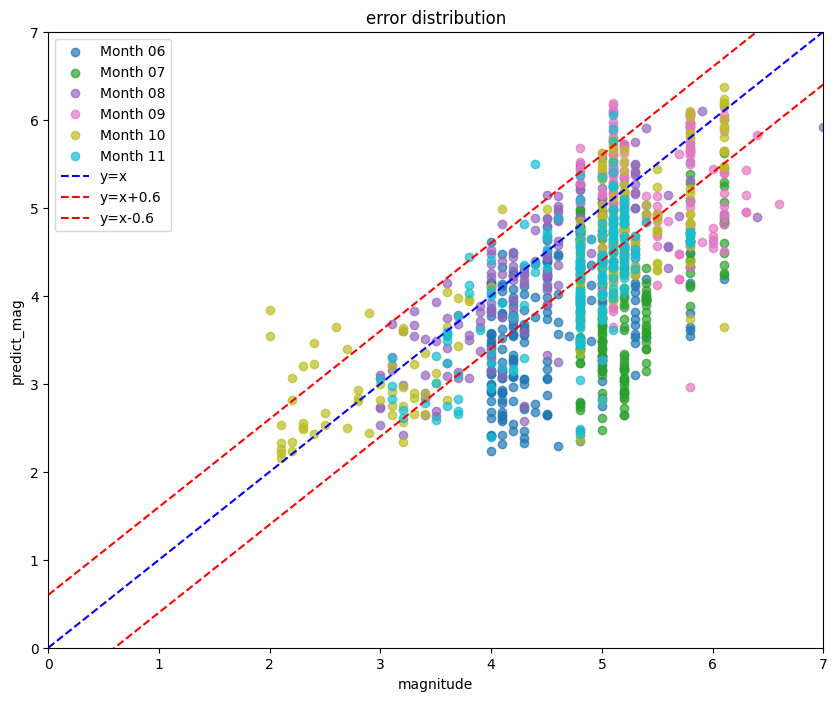

In [6]:
months = ['06', '07', '08', '09', '10','11']
#months = ['08', '09', '10']
colors = plt.cm.tab10(np.linspace(0, 1, len(months)))  # 使用viridis色彩映射 

# 创建图形
plt.figure(figsize=(10, 8))

# 循环绘制每个月份的数据
for i, month in enumerate(months):
    data = pd.read_csv("./emg_output_%s.txt" % month, sep='\s+')
    x = data.iloc[:, 1]
    y = data.iloc[:, 2]
    
    #后处理尝试
    #y = np.exp(y/3)
    # 使用不同颜色绘制散点图，并添加标签
    plt.scatter(x, y, color=colors[i], label=f'Month {month}', alpha=0.7)

# 设置图表属性
plt.xlabel('magnitude')
plt.ylabel('predict_mag')
plt.title('error distribution')
plt.xlim(0, 7)   
plt.ylim(0, 7)

# 添加y=x参考线
xmin, xmax = plt.xlim()
# 1. y = x 参考线（蓝色虚线）
plt.plot([xmin, xmax], [xmin, xmax], 'b--', label='y=x', linewidth=1.5)
# 2. y = x + 0.6 参考线（红色虚线）
plt.plot([xmin, xmax], [xmin + 0.6, xmax + 0.6], 'r--', label='y=x+0.6', linewidth=1.5)
# 3. y = x - 0.6 参考线（红色虚线）
plt.plot([xmin, xmax], [xmin - 0.6, xmax - 0.6], 'r--', label='y=x-0.6', linewidth=1.5)
# 添加图例
plt.legend()

plt.show()

In [ ]:
#把震级2.00-6.10按照0.3等分成7段，求每段所包含地震事件误差的平均值
month = '10'
data = pd.read_csv("./emg_output_%s.txt" % month, sep='\s+')
sum = np.zeros((7,3))
for i in range(0,len(data)):
    emg_answer = data.iloc[i,1]
    emg_diff = data.iloc[i,3]
    if emg_answer >= 2.00 and emg_answer < 2.60:
        sum[0,0] += emg_diff
        sum[0,1] += 1
    elif emg_answer >= 2.60 and emg_answer < 3.20:
        sum[1,0] += emg_diff
        sum[1,1] += 1
    elif emg_answer >= 3.20 and emg_answer < 3.80:
        sum[2,0] += emg_diff
        sum[2,1] += 1
    elif emg_answer >= 3.80 and emg_answer < 4.40:
        sum[3,0] += emg_diff
        sum[3,1] += 1
    elif emg_answer >= 4.40 and emg_answer < 5.00:
        sum[4,0] += emg_diff
        sum[4,1] += 1
    elif emg_answer >= 5.00 and emg_answer < 5.60:
        sum[5,0] += emg_diff
        sum[5,1] += 1
    elif emg_answer >= 5.60:
        sum[6,0] += emg_diff
        sum[6,1] += 1
sum[0,2] = sum[0,0]/sum[0,1]
sum[1,2] = sum[1,0]/sum[1,1]
sum[2,2] = sum[2,0]/sum[2,1]
sum[3,2] = sum[3,0]/sum[3,1]
sum[4,2] = sum[4,0]/sum[4,1]
sum[5,2] = sum[5,0]/sum[5,1]
sum[6,2] = sum[6,0]/sum[6,1]
print(sum)
#画图
x = [2.00,2.60,3.20,3.80,4.40,5.00,5.60] #写入震级
y1 = sum[:,1]
y2 = sum[:,2]
fig, axs = plt.subplots(2, 1)  # 创建2行1列的子图
axs[0].scatter(x, y1) 
plt.ylabel('num')
axs[1].scatter(x, y2)
plt.xlabel('magnitude')
plt.ylabel('ave_error')
plt.show()

